In [1]:
# %matplotlib inline
# %matplotlib widget
# %matplotlib notebook

import warnings
warnings.filterwarnings(action='ignore')

import sys
sys.path.append('../stimulus_core/')
sys.path.append('../models_core/')
sys.path.append('../helper/')

import os
import numpy as np
import tensorflow as tf
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from  matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
import imageio
import time
import importlib
import glob
from scipy.ndimage import gaussian_filter
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans,SpectralClustering
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import metrics
from scipy.spatial import distance_matrix,distance
from scipy.cluster import hierarchy

import dynamics_3d as dn3d
import optical_signal as opsg
import predefined_weights as pdwt
import samples_generation_multi_cells as smgnmc
import flow_field as flfd
import helper_functions as hpfn

In [54]:
# Run this cell if anything is changed in those .py files
importlib.reload(opsg)
importlib.reload(pdwt)
importlib.reload(smgn)
importlib.reload(flfd)
importlib.reload(hpfn)

<module 'helper_functions' from '/Users/bhzhou01/Google Drive/research/loom_local/code/helper_functions.py'>

In [16]:
def get_normalized_vector(vec):
    norm = np.linalg.norm(vec)
    if norm == 0: 
        raise Exception('The norm of the vec is 0!')
    else:
        return vec/norm

    
def get_coords_circumf(x_axis, y_axis, z_axis, angle, N):
    r = np.tan(angle)
    c_vec_list = []
    for n in range(N):
        theta_ = 2*np.pi*(n/N)
        r_vec = x_axis*r*np.sin(theta_) + y_axis*r*np.cos(theta_)
        c_vec = z_axis + r_vec
        c_vec = get_normalized_vector(c_vec)
        c_vec_list.append(c_vec)
    return c_vec_list


def get_angles_on_map(vec):
    rn = 2*(np.random.random()-0.5)*0
    vec = vec + rn
    lat = np.arctan(vec[0]/(np.sqrt(vec[1]**2+vec[2]**2)))
    vec_yz = np.array([0, vec[1], vec[2]])
    vec_yz = get_normalized_vector(vec_yz)
    lon = np.sign(vec[1])*np.arccos(np.dot(vec_yz, np.array([0, 0, 1])))
    
    return np.array([lon, lat])


def get_projection_one_unit(angle_qc, angle_q, angle_r, N):
    x_axis = np.array([[1., 0, 0]])
    y_axis = np.array([[0, 1., 0]])
    z_axis = np.array([[0, 0, 1.]])
    x_axis = opsg.get_rotated_axes(angle_q, x_axis)
    y_axis = opsg.get_rotated_axes(angle_q, y_axis)
    z_axis = opsg.get_rotated_axes(angle_q, z_axis)
    c_vec_list = get_coords_circumf(x_axis, y_axis, z_axis, angle_r, N)
    
    angles_on_map = []
    a = 1e-3
    x_axis_rot = opsg.get_rotated_coordinates(-angle_qc, x_axis)
    y_axis_rot = opsg.get_rotated_coordinates(-angle_qc, y_axis)
    z_axis_rot = opsg.get_rotated_coordinates(-angle_qc, z_axis)
    angles_on_map.append(get_angles_on_map(a*x_axis_rot[0]+z_axis_rot[0]))
    angles_on_map.append(get_angles_on_map(a*y_axis_rot[0]+z_axis_rot[0]))
    angles_on_map.append(get_angles_on_map(z_axis_rot[0]))
    
    for c_vec in c_vec_list:
        c_vec_rot = opsg.get_rotated_coordinates(-angle_qc, c_vec)
        angles_on_map.append(get_angles_on_map(c_vec_rot[0]))
    c_vec_rot = opsg.get_rotated_coordinates(-angle_qc, c_vec_list[0])
    angles_on_map.append(get_angles_on_map(c_vec_rot[0]))
        
    return angles_on_map


def get_segments(angles_on_map):
    L = len(angles_on_map)
    indL = 0
    indR = 0
    segments_list = []
    while indR <= L-1:
        valueR1 = angles_on_map[indR][0]
        if indR < L-1:
            valueR2 = angles_on_map[indR+1][0]
        if np.abs(valueR1-valueR2) >= 3 or indR == L-1:
            segments_list.append(np.array(angles_on_map[indL:indR+1]))
            indL = indR+1
        indR = indR+1
    return segments_list


def get_upper_lower_bound(segment, center):
    segment_diff = np.diff(segment[:, 0])
    L = len(segment_diff)
    for ll in range(L):
        if ll <= L-2 and segment_diff[ll]*segment_diff[ll+1] <= 0:
            segment = np.roll(segment, -ll-1, axis=0)
            segment_diff = np.diff(segment[:, 0])
            for lll in range(L):
                if lll <= L-2 and segment_diff[lll]*segment_diff[lll+1] <= 0:
                    segment1 = segment[:lll+2, :]
                    segment2 = segment[lll+2:, :]
                    if segment[0, 1] >= segment[-1, 1]:
                        segment_upper = segment1
                        segment_lower = segment2
                        if segment_upper[:, 1].min() > segment_lower[:, 1].max():
                            segment_upper = np.concatenate((segment_upper, segment2[0:1, :]), axis=0)
                            segment_upper[-1, 1] = segment_lower[:, 1].max()
                    else:
                        segment_upper = segment2
                        segment_lower = segment1
                        if segment_upper[:, 1].min() > segment_lower[:, 1].max():
                            segment_lower = np.concatenate((segment_lower, segment2[0:1, :]), axis=0)
                            segment_lower[-1, 1] = segment_upper[:, 1].min()
            break
        if ll == L-1:
            if center[1] >= 0:
                segment_upper = np.ones_like(segment)*np.pi/2
                segment_upper[:, 0] = segment[:, 0]
                segment_lower = segment[:, :]
            else:
                segment_upper = segment[:, :]
                segment_lower = np.ones_like(segment)*np.pi/2
                segment_lower[:, 0] = segment[:, 0]

    return segment_lower, segment_upper

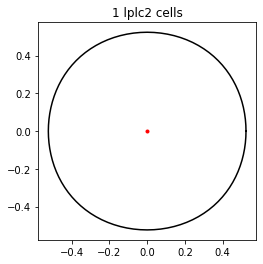

In [17]:
Q = 1
lplc2_units = opsg.get_lplc2_units_xy_angles(Q)
# _, lplc2_units_coords = opsg.get_lplc2_units(Q)

N = 100
qc = 0
angle_qc = lplc2_units[qc]
angle_r = np.pi/6.

fig = plt.figure()
for q in range(Q):
    angle_q = lplc2_units[q]
    angles_on_map = get_projection_one_unit(angle_qc, angle_q, angle_r, N)
    plt.scatter(angles_on_map[0][0], angles_on_map[0][1], c='r', marker='.')
    if q == qc:
        segments_list = get_segments(angles_on_map[3:])
        for segment in segments_list:
            plt.plot(segment[:, 0], segment[:, 1], c='k')
plt.gca().set_aspect('equal', adjustable='box')
plt.title('{} lplc2 units'.format(Q))        
plt.show()

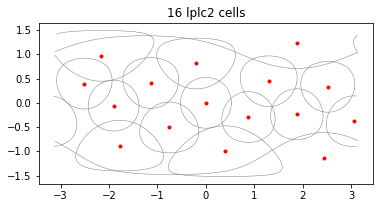

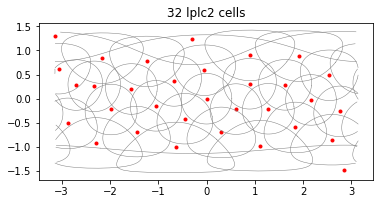

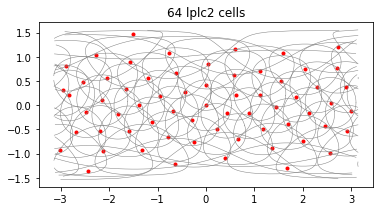

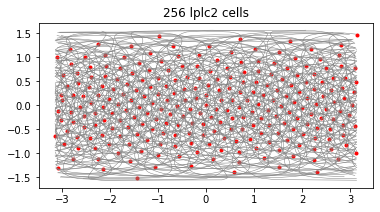

In [18]:
N = 100
qc = 1
angle_r = np.pi/6

for Q in [16, 32, 64, 256]:
    lplc2_units = opsg.get_lplc2_units_xy_angles(Q)
    _, lplc2_units_coords = opsg.get_lplc2_units(Q)
    angle_qc = lplc2_units[qc]

    fig = plt.figure()
    for q in range(Q):
        angle_q = lplc2_units[q]
        angles_on_map = get_projection_one_unit(angle_qc, angle_q, angle_r, N)
        plt.scatter(angles_on_map[0][0], angles_on_map[0][1], c='r', marker='.')
        segments_list = get_segments(angles_on_map[3:])
        for segment in segments_list:
            plt.plot(segment[:, 0], segment[:, 1], c=[0.5, 0.5, 0.5], linewidth=0.5)
    plt.title('{} lplc2 units'.format(Q))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    fig.savefig(figure_path+'projection_{}.pdf'.format(Q), bbox_inches='tight')

## Results with predefined weights

(217, 1, 3)
saving
saving


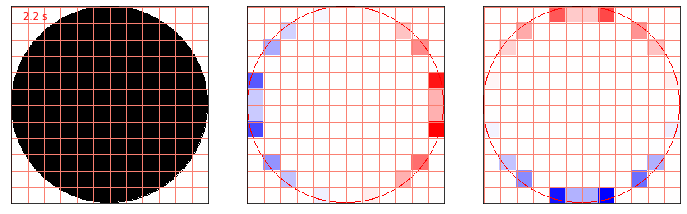

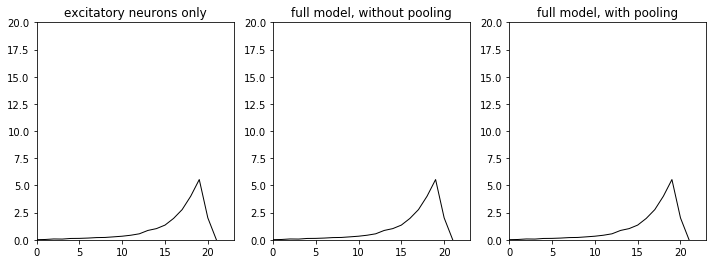

In [18]:
# Plot the response of LPLC2 with predefined weights
importlib.reload(opsg)
importlib.reload(pdwt)
importlib.reload(flfd)
importlib.reload(hpfn)

# signals
dt = 0.01 # time step (sec)
sample_dt = 0.1
delay_dt = 0.03
dynamics_fun = dn3d.dynamics_fun_zero_field # dynamics that is imposed on the object
eta_1 = 0. # random force added on the ball (m/sec^2)
sigma = 0. # noise added to images
K = 12
L = 20
fps = np.int(1./sample_dt) # frames per sec
filename = '../results/test/test_signal_0.gif'
R = 1 # radius of the ball (m)
x = 0. # x position of the center of the ball (m)
y = 0. # y position of the center of the ball (m)
z = 7.5 # z position of the center of the ball (m)
vx = 0. # x velocity of the ball (m/sec)
vy = 0. # y velocity of the ball (m/sec)
vz = -3. # z velocity of the ball (m/sec)
traj = smgn.generate_one_trajectory(x,y,z,vx,vy,vz,R,dynamics_fun,eta_1,dt)
print(traj.shape)
Rs = np.array([1.])
angn.plot_signal_flow(Rs,traj,dt,sample_dt,delay_dt,K,L,sigma,fps,filename)

# response
pad = 0.
leftup_corners = opsg.get_leftup_corners(K,L,pad)
theta_dt = 45 # angle to generate the local weights
weights_e1 = pdwt.get_all_weights_e(leftup_corners,theta_dt,K,L,scl=1)
intercept_e1 = 0.
weights_e2 = weights_e1
weights_i2 = pdwt.get_all_weights_i(leftup_corners,theta_dt,K,L,scl=1)
intercept_e2 = 0.
intercept_i2 = 0.
weights_e3 = weights_e1
weights_i3 = weights_i2
intercept_e3 = 0.
intercept_i3 = 0.
n = 0 # filter order, 0 means no filter
tau_1 = 0.5 # timescale of the filter (sec)
a = 1.
b = 0.
filename = '../results/test/test_reponse_0.gif'

angn.plot_response(Rs,traj,dt,sample_dt,delay_dt,K,L,sigma,\
                  weights_e1,intercept_e1,\
                  weights_e2,weights_i2,intercept_e2,intercept_i2,\
                  weights_e3,weights_i3,intercept_e3,intercept_i3,n,tau_1,a,b,fps,filename)

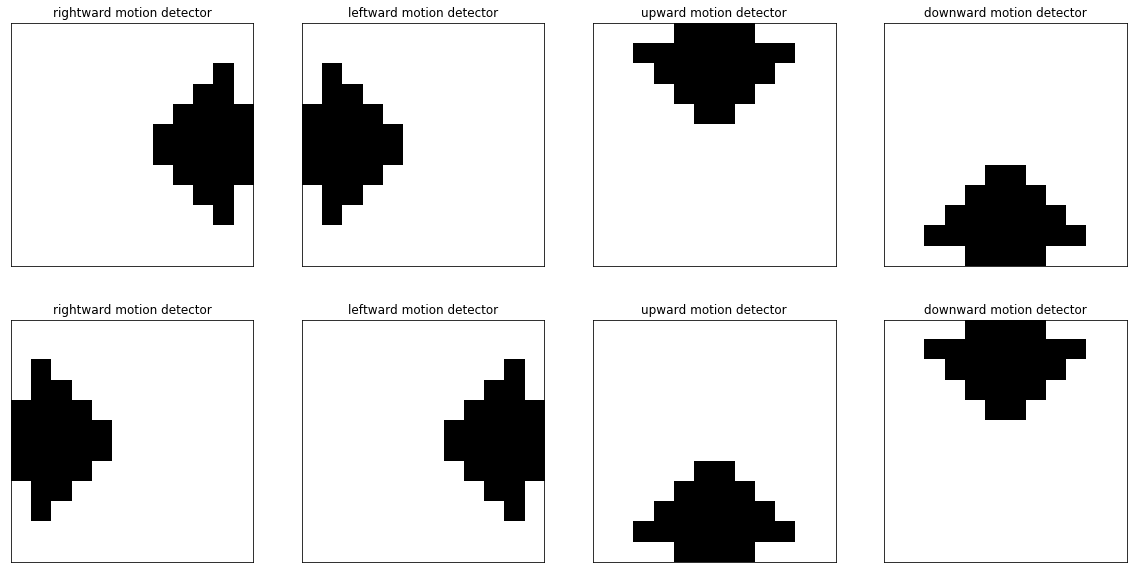

In [7]:
# Plot the predefined weights
importlib.reload(hpfn)
importlib.reload(pdwt)

K = 12
L = 20
theta_dt = 45
hpfn.plot_predefined_weights(theta_dt,K,L,'../results/test/predefined_weights_{}.pdf'.format(theta_dt))

# Models with one LPLC2 cell

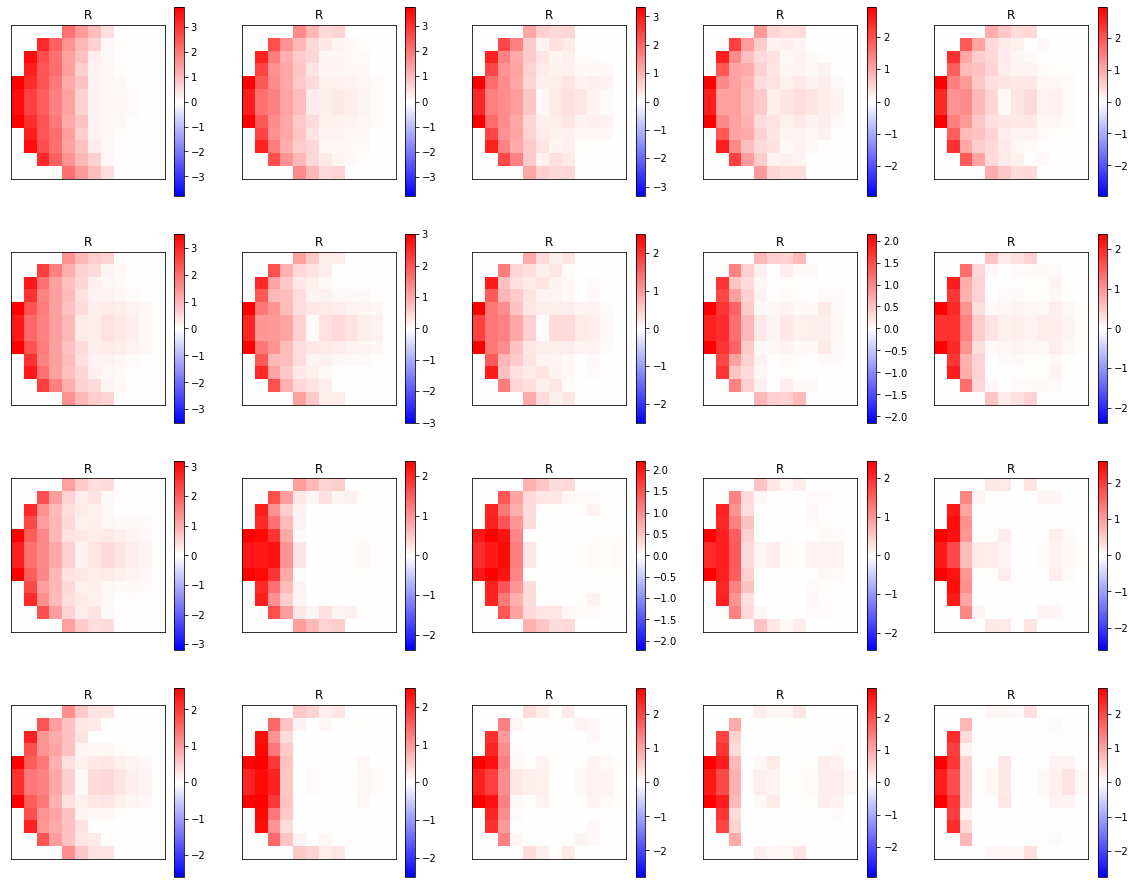

In [16]:
importlib.reload(hpfnbz)

# with natural scene
path = '../results'
folder_names = [['set_102_EN_False','set_105_EN_False','set_110_EN_False','set_115_EN_False','set_120_EN_False'],
                ['set_302_EN_False','set_305_EN_False','set_310_EN_False','set_315_EN_False','set_320_EN_False'],
                ['set_602_EN_False','set_605_EN_False','set_610_EN_False','set_615_EN_False','set_620_EN_False'],
                ['set_1002_EN_False','set_1005_EN_False','set_1010_EN_False','set_1015_EN_False','set_1020_EN_False']]
model_types = ['excitatory','inhibitory1','inhibitory2']
condition = 'MR_False_TF_False_LT_False_tau_1'
weight_types = ['trained_weights_e','trained_weights_i']
natural = ['withn','withoutn']
weight_mask = opsg.get_disk_mask(12,20)
colormap = 'bwr'

hpfnbz.plot_sym_flow_weights_grid(path,natural[0],folder_names,model_types[1],condition,weight_types[1],weight_mask,colormap)

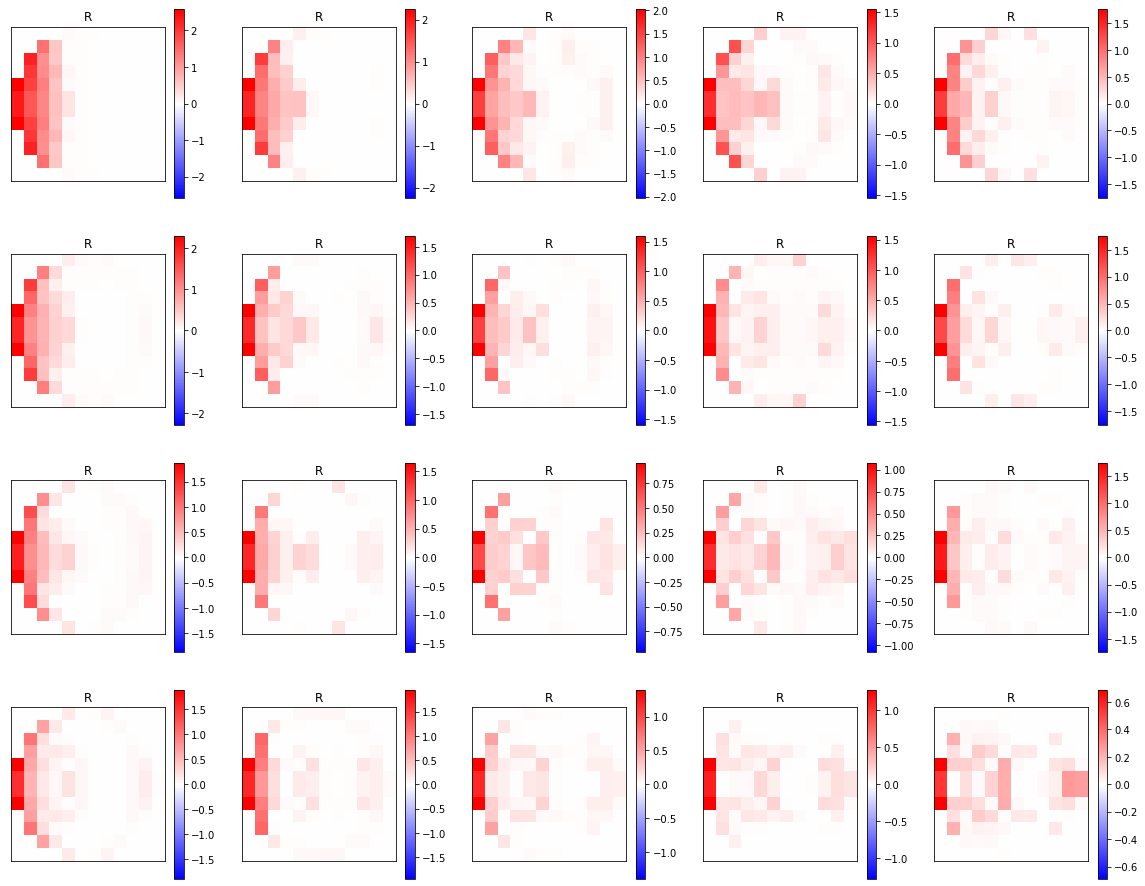

In [18]:
# without natural scene
path = '../results'
folder_names = [['set_102_EN_True','set_105_EN_True','set_110_EN_True','set_115_EN_True','set_120_EN_True'],
                ['set_302_EN_True','set_305_EN_True','set_310_EN_True','set_315_EN_True','set_320_EN_True'],
                ['set_602_EN_True','set_605_EN_True','set_610_EN_True','set_615_EN_True','set_620_EN_True'],
                ['set_1002_EN_True','set_1005_EN_True','set_1010_EN_True','set_1015_EN_True','set_1020_EN_True']]
model_types = ['excitatory','inhibitory1','inhibitory2']
condition = 'MR_False_TF_False_LT_False_tau_1'
weight_types = ['trained_weights_e','trained_weights_i']
natural = ['withn','withoutn']
weight_mask = opsg.get_disk_mask(12,20)
colormap = 'bwr'

hpfnbz.plot_sym_flow_weights_grid(path,natural[1],folder_names,model_types[1],condition,weight_types[1],weight_mask,colormap)

# Response grid

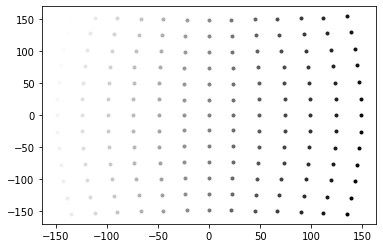

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

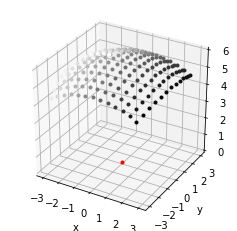

In [57]:
importlib.reload(hpfnbz)

D = 6
theta_r = np.deg2rad(30)
K = 12
L = 25

grid_init = hpfnbz.get_grid_init(D)
init_onframe = hpfnbz.get_grid_init_on_frame(grid_init,theta_r,K,L)

%matplotlib inline
n = 0
for i in range(13):
    for j in range(13):
        plt.plot([init_onframe[i,j,0]],[init_onframe[i,j,1]],color='{}'.format(n/169.),marker='.')
        n = n+1
plt.show()

%matplotlib widget
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1,1,1,projection='3d')
n = 0
for i in range(13):
    for j in range(13):
        ax.plot([grid_init[i,j,0]],[grid_init[i,j,1]],[grid_init[i,j,2]],color='{}'.format(n/169.),marker='.')
        n = n+1
ax.plot([0],[0],[0],'r.')    
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [10]:
importlib.reload(hpfnbz)

D = 10
R = 1 # radius of the ball (m)
dt = 0.01 # time step (sec)
dynamics_fun = dn3d.dynamics_fun_zero_field # dynamics that is imposed on the object
eta_1 = 0. # random force added on the ball (m/sec^2)
sigma = 0. # noise added to images
theta_r = np.deg2rad(30) # half of the receptive field width (rad)
K = 12 # K*K is the total number of cells
L = 20 # L is the dimension of each cell
sample_dt = 0.1 # sampling resolution
delay_dt = 0.03 # delay in the motion detector
V = 5.*R # maximum speed (m/sec)

# path to save the sample data
savepath = '/Users/bhzhou01/data_on_mac/loom/grid_conv/'
hpfnbz.generate_samples_grid_conv(D,V,R,dt,dynamics_fun,eta_1,sigma,theta_r,K,L,sample_dt,delay_dt,savepath)

# path to save the sample data
savepath = '/Users/bhzhou01/data_on_mac/loom/grid_div/'
hpfnbz.generate_samples_grid_div(D,V,R,dt,dynamics_fun,eta_1,sigma,theta_r,K,L,sample_dt,delay_dt,savepath)

# path to save the sample data
savepath = '/Users/bhzhou01/data_on_mac/loom/grid_para/'
hpfnbz.generate_samples_grid_para(D,V,R,dt,dynamics_fun,eta_1,sigma,theta_r,K,L,sample_dt,delay_dt,savepath)

In [99]:
# TEST of the generated samples
importlib.reload(flfd)
importlib.reload(smgn)
importlib.reload(opsg)

i = 6
j = 6

K = 12
L = 20
pad = 2*L

frames_cg = np.load('/Users/bhzhou01/data_on_mac/loom/grid_para/frames_samples_cg/frames_sample_cg_{}_{}.npy'.format(i,j))
steps = frames_cg.shape[0]
print(frames_cg.shape)
frames_cg1 = np.zeros((steps,K,K))
for step in range(steps):
    frames_cg1[step,:,:] = frames_cg[step,0,:].reshape((K,K))[:,:]
imageio.mimwrite('../results/test/frames_sample_cg_{}_{}.mp4'.format(i,j),\
                 frames_cg1,fps = 10,macro_block_size=16)


leftup_corners = opsg.get_leftup_corners(K,L,pad)
UV_flow = np.load('/Users/bhzhou01/data_on_mac/loom/grid_para/UV_flow_samples/UV_flow_sample_{}_{}.npy'.format(i,j))
steps = UV_flow.shape[0]
print(UV_flow.shape)
u_flow = np.zeros((steps,K*L,K*L))
v_flow = np.zeros((steps,K*L,K*L))
for step in range(steps):
    cf_u,cf_v = flfd.set_flow_fields_on_frame(UV_flow[step,:,:,:],leftup_corners,K,L,pad)
    u_flow[step,:,:] = cf_u[0,:,:]
    v_flow[step,:,:] = cf_v[0,:,:]
imageio.mimwrite('../results/test/U_flow_sample_{}_{}.mp4'.format(i,j),\
                 u_flow,fps = 10,macro_block_size=16)
imageio.mimwrite('../results/test/V_flow_sample_{}_{}.mp4'.format(i,j),\
                 v_flow,fps = 10,macro_block_size=16)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (12, 12) to (16, 16) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to sav

(24, 1, 144)
(24, 1, 144, 4)


Lossy conversion from float64 to uint8. Range [-0.005095183849334717, 0.005314379930496216]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04234519600868225, 0.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.048298776149749756, 0.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.013929784297943115, 0.018808335065841675]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.008541107177734375, 0.016300737857818604]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.035474568605422974, 1.4455103780619538e-12]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.02280852198600769, 0.02469217777252

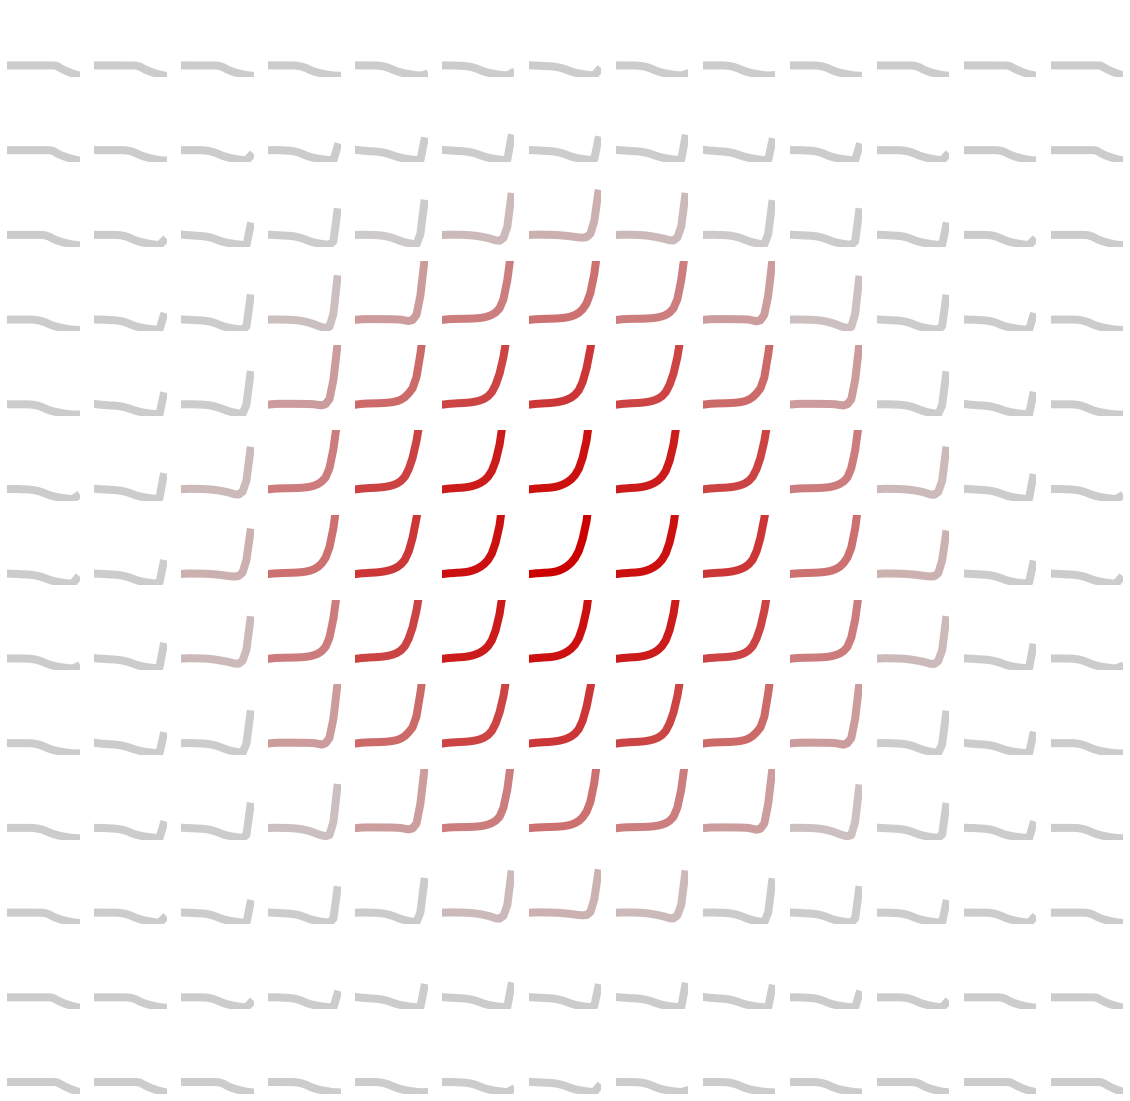

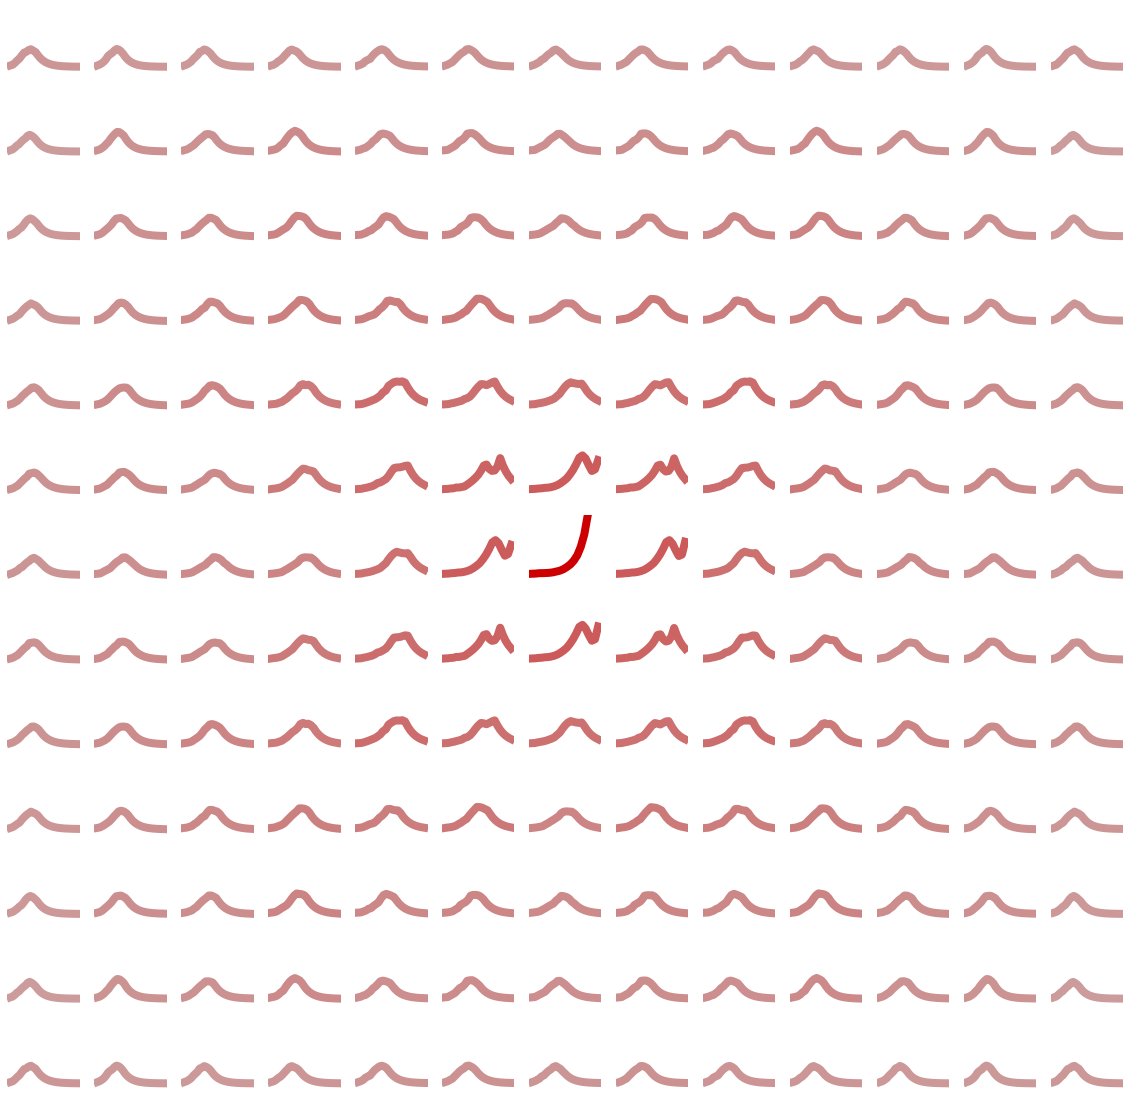

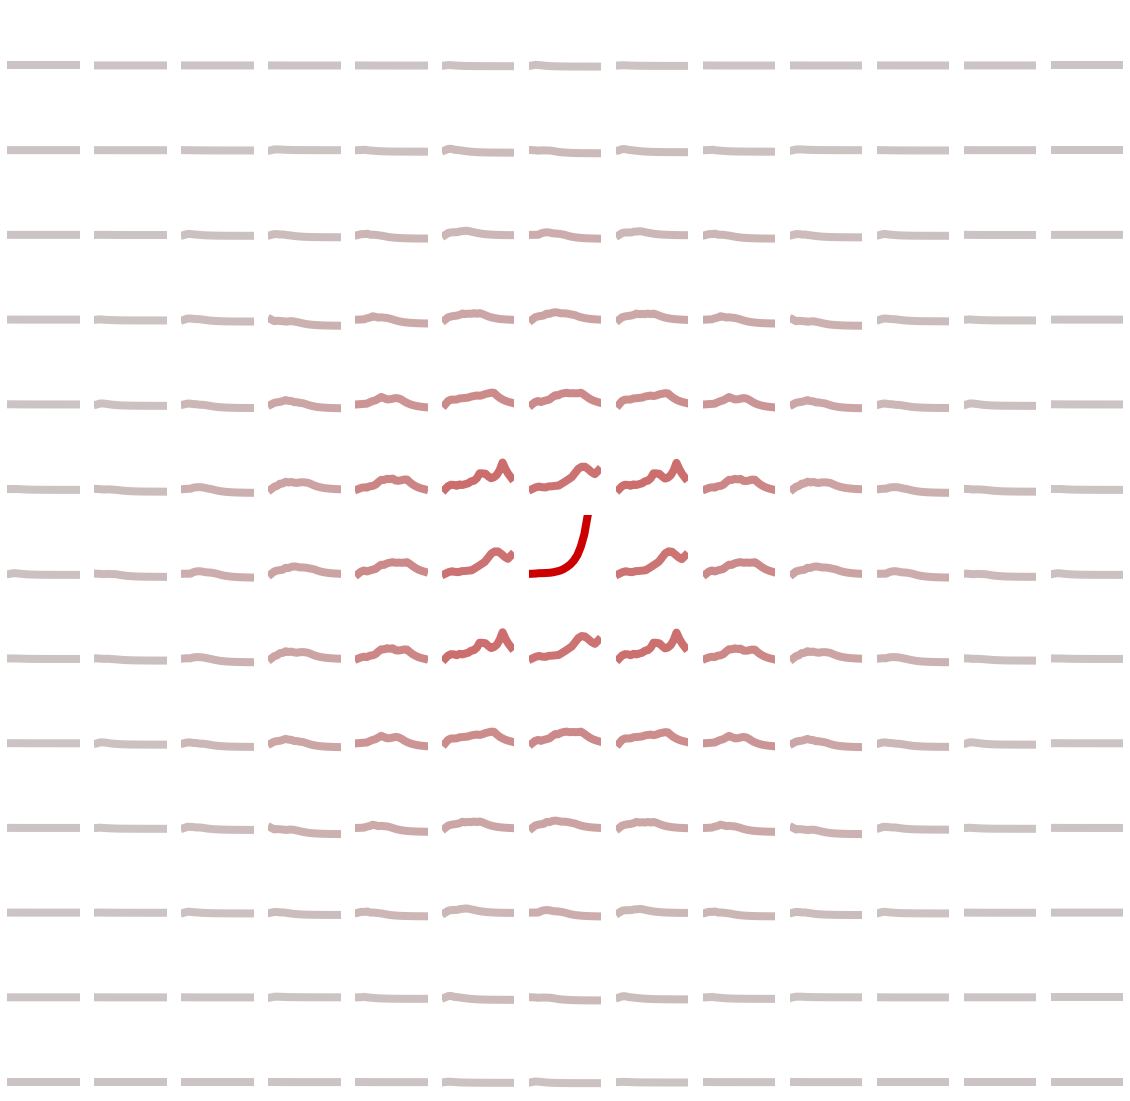

In [13]:
importlib.reload(hpfnbz)

# model
args = {}
args["n"] = 0
args["dt"] = 0.1
args["use_intensity"] = False
args["symmetrize"] = True
args['K'] = 12
args['alpha_leak'] = 0.02
args['Q'] = 1

data_set = 'set_102_EN_False'
model_types = ['excitatory','excitatory_WNR', 'inhibitory1', 'inhibitory2']
conditions = ['MR_False_TF_False_LT_True','MR_True_TF_False_LT_True',\
              'MR_True_TF_True_LT_False','MR_True_TF_True_LT_True','MR_False_TF_False_LT_False']
tau_names = ['','_tau_0','_tau_1','_tau_2','_tau_3','_tau_4']
tau_values = [1.,1.,0.368,0.135,0.05,0.018]
temporal_filter = [False,True,True,True,True,True]

tau_name = '_tau_1'
args['temporal_filter'] = temporal_filter[tau_names.index(tau_name)]
args['tau_1'] = tau_values[tau_names.index(tau_name)]
model_type = model_types[2]
model_path = '../results/'+data_set+'/'+model_type+'/'+conditions[-1]+tau_name+'/'

%matplotlib inline

data_path = '/Users/bhzhou01/data_on_mac/loom/set_grid/grid_conv/'
filename = '../results/response_grid_conv2.png'
hpfnbz.generate_response_grid(args,model_path,model_type,data_path,filename,intensity=0)

data_path = '/Users/bhzhou01/data_on_mac/loom/set_grid/grid_div/'
filename = '../results/response_grid_div2.png'
hpfnbz.generate_response_grid(args,model_path,model_type,data_path,filename,intensity=0)

data_path = '/Users/bhzhou01/data_on_mac/loom/set_grid/grid_para/'
filename = '../results/response_grid_para2.png'
hpfnbz.generate_response_grid(args,model_path,model_type,data_path,filename,intensity=0)

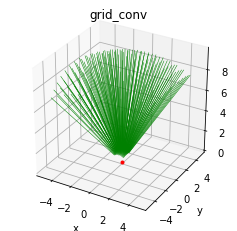

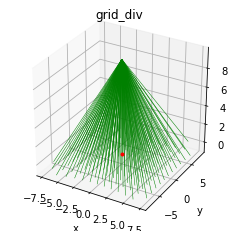

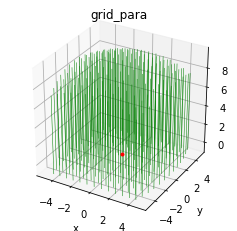

In [138]:
importlib.reload(hpfnbz)

colors = ['g']

datapath = '/Users/bhzhou01/data_on_mac/loom/set_grid/'
file_types = ['grid_conv']
filename = 'trajectories_conv.pdf'
if os.path.isdir(datapath):
    hpfnbz.plot_trajectories(datapath,file_types,colors,filename)
    
datapath = '/Users/bhzhou01/data_on_mac/loom/set_grid/'
file_types = ['grid_div']
filename = 'trajectories_div.pdf'
if os.path.isdir(datapath):
    hpfnbz.plot_trajectories(datapath,file_types,colors,filename)
    
datapath = '/Users/bhzhou01/data_on_mac/loom/set_grid/'
file_types = ['grid_para']
filename = 'trajectories_para.pdf'
if os.path.isdir(datapath):
    hpfnbz.plot_trajectories(datapath,file_types,colors,filename)

# Models with a group of LPLC2 cells

In [32]:
importlib.reload(opsg)
importlib.reload(hpfnbz)

# data
K = 12
KK = K**2
savepath = '/Users/bhzhou01/data_on_mac/loom/'
set_number = 605
datatype = 'natural'
sample_number = 4
path = savepath+'set_{}/'.format(set_number)+'training'+'/'+datatype+'/'
frames_sample_cg = np.load(path+'frames_samples_cg/frames_sample_cg_{}.npy'.format(sample_number))
UV_flow_sample = np.load(path+'UV_flow_samples/UV_flow_sample_{}.npy'.format(sample_number))
print(frames_sample_cg.shape)
print(UV_flow_sample.shape)
steps = frames_sample_cg.shape[0]
Q = frames_sample_cg.shape[1]
sqrt_Q = np.int(np.sqrt(Q))
frames_sample_cg_lplc2 = np.ones((steps,sqrt_Q*K+(sqrt_Q-1)*1,sqrt_Q*K+(sqrt_Q-1)*1))*0.1

path_traj = savepath+'set_{}/'.format(set_number)+'other_info'+'/'+datatype+'/'+'trajectories/'
traj = np.load(path_traj+'traj_{}.npy'.format(sample_number))
print(traj.shape)
print('starting coordinates is ', traj[0,0,:])
print('ending coordinates is', traj[-1,0,:])
x,y,z = traj[-1,0,:]
print('ending distance is', dn3d.get_radial_distance(x,y,z))
vec = traj[0,0,:]-traj[1,0,:]
angles = opsg.get_angles_between_lplc2_and_vec(Q,vec)
sorted_list = list(np.argsort(angles))

for step in range(steps):
    for q in range(Q):
        row = np.int(q/sqrt_Q)
        col = np.mod(q,sqrt_Q)
        frames_sample_cg_lplc2[step,row*(K+1):row*(K+1)+K,col*(K+1):col*(K+1)+K] = frames_sample_cg[step,sorted_list[q],:].reshape((K,K))

imageio.mimwrite('../results/test/lplc2_fields/lplc2_fields_test_'+datatype+'_{}_{}.mp4'.format(set_number,sample_number),\
                 frames_sample_cg_lplc2,fps = 10,macro_block_size=16)

# model
args = {}
args["n"] = 0
args["dt"] = 0.1
args["use_intensity"] = False
args["symmetrize"] = True
args['K'] = 12

model_folder = 'model_weights_420'
data_set = 'set_402_EN_False'
model_types = ['excitatory','excitatory_WNR', 'inhibitory1', 'inhibitory2']
conditions = ['MR_False_TF_False_LT_True','MR_True_TF_False_LT_True',\
              'MR_True_TF_True_LT_False','MR_True_TF_True_LT_True','MR_False_TF_False_LT_False']
tau_names = ['','_tau_0','_tau_1','_tau_2','_tau_3','_tau_4']
tau_values = [1.,1.,0.368,0.135,0.05,0.018]
temporal_filter = [False,True,True,True,True,True]

tau_name = '_tau_2'
args['temporal_filter'] = temporal_filter[tau_names.index(tau_name)]
args['tau_1'] = tau_values[tau_names.index(tau_name)]
model_type = model_types[3]
model_path = '../results/'+model_folder+'/'+data_set+'/'+model_type+'/'+conditions[-1]+tau_name+'/'

fig = plt.figure(figsize=(18,18))
for q in range(Q):
    print(angles[sorted_list[q]])
    UV_flow = UV_flow_sample[:,sorted_list[q],:,:]
    UV_flow = np.expand_dims(UV_flow, axis=1)
    res_T = hpfnbz.get_response_over_time(args,model_path,model_type,UV_flow)
    row = np.int(q/sqrt_Q)
    col = np.mod(q,sqrt_Q)
    plt.subplot(sqrt_Q,sqrt_Q,q+1)
    plt.plot(res_T,c='k',linewidth=4)
#     plt.xticks([])
#     plt.yticks([])
fig.savefig('../results/test/lplc2_fields/lplc2_fields_test_'+datatype+'_{}_{}.pdf'.format(set_number,sample_number),bbox_inches='tight')

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (12, 12) to (16, 16) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to sav

(20, 1, 144)
(20, 1, 144, 4)
(200, 200, 3)
starting coordinates is  [-7.81693135  5.57144778 -5.66025912]
ending coordinates is [-5.10358003 -9.90641599  0.01930162]
ending distance is 11.143786583227259
135.1954692582432


KeyError: 'alpha_leak'

<Figure size 1296x1296 with 0 Axes>

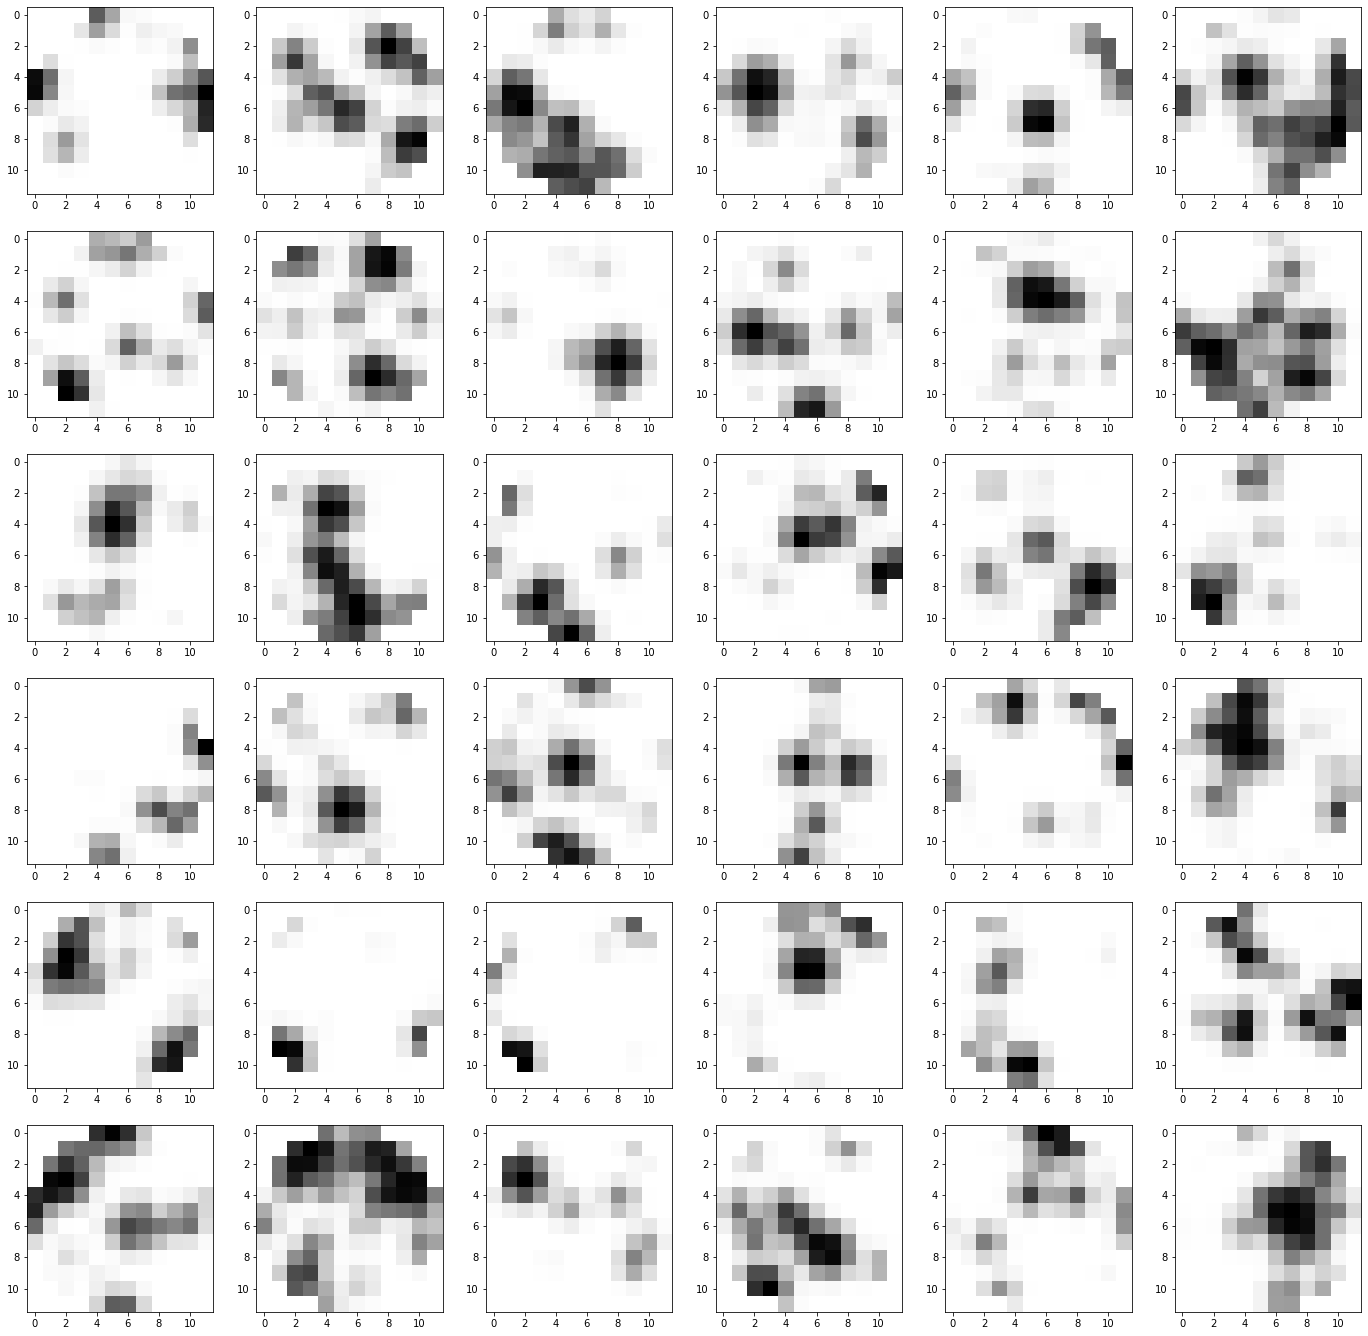

In [6]:
fig = plt.figure(figsize=(4*np.int(np.sqrt(Q)),4*np.int(np.sqrt(Q))))
for q in range(Q):
    plt.subplot(np.int(np.sqrt(Q)),np.int(np.sqrt(Q)),q+1)
    plt.imshow(frames_sample_cg[-1,sorted_list[q],:].reshape((K,K)),cmap='gray_r',alpha=1.)

In [131]:
importlib.reload(hpfnbz)

# model
args = {}
args["n"] = 0
args["dt"] = 0.1
args["use_intensity"] = False
args["symmetrize"] = True
args['K'] = 12

data_set = 'set_401_EN_True'
model_types = ['excitatory','excitatory_WNR', 'inhibitory1', 'inhibitory2']
conditions = ['MR_False_TF_False_LT_True','MR_True_TF_False_LT_True',\
              'MR_True_TF_True_LT_False','MR_True_TF_True_LT_True','MR_False_TF_False_LT_False']
tau_names = ['','_tau_0','_tau_1','_tau_2','_tau_3','_tau_4']
tau_values = [1.,1.,0.368,0.135,0.05,0.018]
temporal_filter = [False,True,True,True,True,True]

model_folder = 'model_weights_420'
tau_name = '_tau_2'
args['temporal_filter'] = False
args['tau_1'] = tau_values[tau_names.index(tau_name)]
model_type = model_types[0]
model_path = '../results/'+model_folder+'/'+data_set+'/'+model_type+'/'+conditions[-1]+tau_name+'/'

data_path = '/Users/bhzhou01/data_on_mac/loom/'
set_number = 925
data_type = 'nohit'
M = 250

closest_dist,probability = hpfnbz.get_probability(args,model_path,model_type,data_path,set_number,data_type,M)

%matplotlib inline

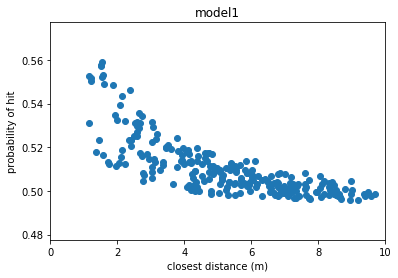

In [132]:
plt.scatter(closest_dist,probability)
plt.xlim([0,10])
plt.xlabel('closest distance (m)')
plt.ylabel('probability of hit')
plt.title('model1')
plt.show()

In [32]:
importlib.reload(hpfnbz)

# model
args = {}
args["n"] = 0
args["dt"] = 0.1
args["use_intensity"] = False
args["symmetrize"] = True
args['K'] = 12
args['alpha_leak'] = 0.0
args['Q'] = 128
args['temporal_filter'] = False
args['tau_1'] = 1.

model_types = ['excitatory','excitatory_WNR', 'inhibitory1', 'inhibitory2','hand_tuned']
model_type = model_types[2]
model_path = '../results/test_weights/Q128/'+model_type+'/'

set_number = 1001
data_path = '/Users/bhzhou01/data_on_mac/loom/multi_lplc2/set_{}/'.format(set_number)
data_types = ['hit','nohit']
data_type = data_types[0]

res_max_all,res_T_all,angles_all,steps,distances_min_all = hpfnbz.generate_response_multicell(args,model_path,model_type,data_path,data_type)

KeyboardInterrupt: 

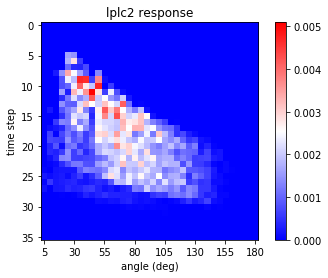

In [19]:
importlib.reload(hpfnbz)
bin_size = 5
max_angle = 180
res_heatmap = hpfnbz.generate_heatmap_multicell(res_T_all,angles_all,steps,bin_size,max_angle)

%matplotlib inline
fig = plt.figure()
plt.imshow(res_heatmap[:,:],cmap = 'bwr')
plt.colorbar()
plt.xlabel('angle (deg)')
plt.ylabel('time step')
plt.xticks(np.arange(0,36,5),np.arange(0,36,5)*5+5)
plt.title('lplc2 response')
plt.show()
filename = '../results/response_grid_multicell_'+model_type+'_'+data_type+'_128.png'
fig.savefig(filename)

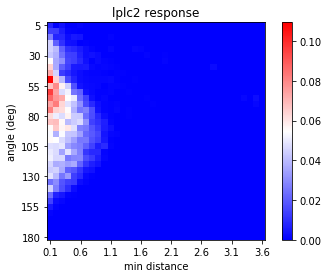

In [29]:
importlib.reload(hpfnbz)
bin_size = 5
max_angle = 180
res_heatmap = hpfnbz.generate_heatmap_multicell_dist(res_max_all,angles_all,steps,bin_size,max_angle,distances_min_all)
dist_min_min = np.floor(min(distances_min_all))
dist_min_max = np.ceil(max(distances_min_all))
bin_size_dist = np.round((dist_min_max-dist_min_min)/36,1)
%matplotlib inline
fig = plt.figure()
plt.imshow(res_heatmap[:,:],cmap = 'bwr')
plt.colorbar()
plt.xlabel('min distance')
plt.ylabel('angle (deg)')
plt.yticks(np.arange(0,36,5),np.arange(0,36,5)*5+5)
plt.xticks(np.arange(0,36,5),np.arange(0,36,5)*bin_size_dist+bin_size_dist)
plt.title('lplc2 response')
plt.show()
filename = '../results/response_grid_multicell_dist_'+model_type+'_'+data_type+'_128.png'
fig.savefig(filename)

In [57]:
importlib.reload(hpfnbz)

# model
args = {}
args["n"] = 0
args["dt"] = 0.1
args["use_intensity"] = False
args["symmetrize"] = True
args['K'] = 12
args['alpha_leak'] = 0.0
args['Q'] = 256

model_types = ['excitatory','excitatory_WNR', 'inhibitory1', 'inhibitory2']

args['temporal_filter'] = False
args['tau_1'] = 1.
model_path = '../results/test_weights_2/Q256/'

set_number = 1256
data_path = '/Users/bhzhou01/data_on_mac/loom/multi_lplc2/set_{}/'.format(set_number)
data_types = ['hit','nohit']
data_type = data_types[0]

bin_size = 5
max_angle = 180

res_max_all_models = hpfnbz.generate_response_multicell_all_models(args,model_path,model_types,data_path,data_type,bin_size,max_angle)

256
256
256
256


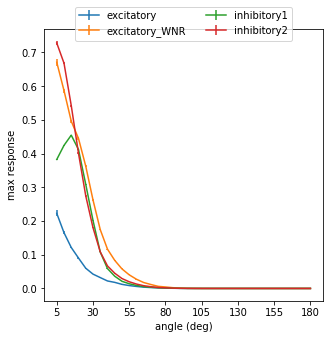

In [58]:
fig = plt.figure(figsize=(5,5))
for res in res_max_all_models:
    plt.errorbar(np.arange(0,36),res[0,:],res[1,:])
    plt.xlabel('angle (deg)')
    plt.ylabel('max response')
#     plt.ylim([0,0.7])
    plt.xticks(np.arange(0,36,5),np.arange(0,36,5)*5+5)
    plt.legend(model_types,loc='upper center', bbox_to_anchor=(0.5, 1.1),ncol=2)
plt.show()

filename = '../results/response_grid_multicell_all_models_'+data_type+'_256.png'
fig.savefig(filename)

In [86]:
importlib.reload(hpfnbz)

# model
args = {}
args["n"] = 0
args["dt"] = 0.1
args["use_intensity"] = False
args["symmetrize"] = True
args['K'] = 12
args['alpha_leak'] = 0.0
args['Q'] = 16
args['temporal_filter'] = False
args['tau_1'] = 1.

model_types = ['inhibitory1','inhibitory2']
model_type = model_types[0]
model_path = '../results/reversed_weights1/'+model_type+'/'

set_number = 900
data_path = '/Users/bhzhou01/data_on_mac/loom/set_{}/'.format(set_number)
data_types = ['hit','nohit']
data_type = data_types[1]

_,res_T_all,angles_all,steps = hpfnbz.generate_response_multicell(args,model_path,model_type,data_path,data_type)

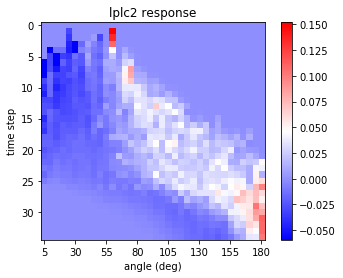

In [87]:
importlib.reload(hpfnbz)
bin_size = 5
max_angle = 180
res_heatmap = hpfnbz.generate_heatmap_multicell(res_T_all,angles_all,steps,bin_size,max_angle)

%matplotlib inline
fig = plt.figure()
plt.imshow(res_heatmap[:,:],cmap = 'bwr')
plt.colorbar()
plt.xlabel('angle (deg)')
plt.ylabel('time step')
plt.xticks(np.arange(0,36,5),np.arange(0,36,5)*5+5)
plt.title('lplc2 response')
plt.show()
filename = '../results/response_grid_multicell_'+model_type+'_'+data_type+'_reversed.png'
fig.savefig(filename)

In [77]:
importlib.reload(hpfnbz)

# model
args = {}
args["n"] = 0
args["dt"] = 0.1
args["use_intensity"] = False
args["symmetrize"] = True
args['K'] = 12
args['alpha_leak'] = 0.0
args['Q'] = 16

model_types = ['inhibitory1', 'inhibitory2']

args['temporal_filter'] = False
args['tau_1'] = 1.
model_path = '../results/reversed_weights2/'

set_number = 900
data_path = '/Users/bhzhou01/data_on_mac/loom/set_{}/'.format(set_number)
data_types = ['hit','nohit']
data_type = data_types[1]

bin_size = 5
max_angle = 180

res_max_all_models = hpfnbz.generate_response_multicell_all_models(args,model_path,model_types,data_path,data_type,bin_size,max_angle)

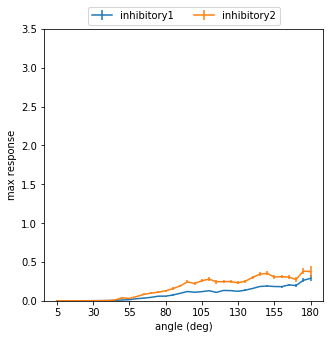

In [78]:
fig = plt.figure(figsize=(5,5))
for res in res_max_all_models:
    plt.errorbar(np.arange(0,36),res[0,:],res[1,:])
    plt.xlabel('angle (deg)')
    plt.ylabel('max response')
    plt.ylim([0,3.5])
    plt.xticks(np.arange(0,36,5),np.arange(0,36,5)*5+5)
    plt.legend(model_types,loc='upper center', bbox_to_anchor=(0.5, 1.1),ncol=2)
plt.show()

filename = '../results/response_grid_multicell_all_models_'+data_type+'_reversed.png'
fig.savefig(filename)

In [16]:
K = 12
steps = frames_sample_cg.shape[0]
Q = frames_sample_cg.shape[1]
sqrt_Q = np.int(np.sqrt(Q))
frames_sample_cg_lplc2 = np.ones((steps,sqrt_Q*K+(sqrt_Q-1)*1,sqrt_Q*K+(sqrt_Q-1)*1))*0.1

for step in range(steps):
    for q in range(Q):
        row = np.int(q/sqrt_Q)
        col = np.mod(q,sqrt_Q)
        frames_sample_cg_lplc2[step,row*(K+1):row*(K+1)+K,col*(K+1):col*(K+1)+K] = frames_sample_cg[step,q,:].reshape((K,K))

imageio.mimwrite('../results/test/lplc2_fields/lplc2_fields_test_0.mp4',\
                 frames_sample_cg_lplc2,fps = 10,macro_block_size=16)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (77, 77) to (80, 80) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to sav

# Landscape of the loss function

In [6]:
Q = 169
result_folder = '/Volumes/Baohua/research_large_files/multi_lplc2_500initials_list_0828/set_1169_R1.0/inhibitory2/ACT_0_0.001/'
subdir_all = []
for subdir, dirs, files in os.walk(result_folder):
    subdir_all.append(subdir)
subdir_all.pop(0)


'/Volumes/Baohua/research_large_files/multi_lplc2_500initials_list_0828/set_1169_R1.0/inhibitory2/ACT_0_0.001/'

In [70]:
initial_weights_e_all = []
initial_weights_i_all = []
trained_weights_e_all = []
trained_weights_i_all = []
auc_scores = []
loss_output_all = []
a_output_all = []
b_output_all = []

for ind,subdir in enumerate(subdir_all):
    if ind == 27:
        print(subdir)
    if os.path.exists(subdir+'/trained_weights_e.npy'):
        initial_weights_e = np.load(subdir+'/initial_weights_e.npy')
        initial_weights_i = np.load(subdir+'/initial_weights_i.npy')
        trained_weights_e = np.load(subdir+'/trained_weights_e.npy')
        trained_weights_i = np.load(subdir+'/trained_weights_i.npy')
        auc_pr = np.load(subdir+'/auc_pr.npy')
        auc_roc = np.load(subdir+'/auc_roc.npy')
        loss_output = np.load(subdir+'/loss_output.npy')
        a_output = np.load(subdir+'/a_output.npy')
        b_output = np.load(subdir+'/b_output.npy')
        initial_weights_e_all.append(initial_weights_e)
        initial_weights_i_all.append(initial_weights_i)
        trained_weights_e_all.append(trained_weights_e)
        trained_weights_i_all.append(trained_weights_i)
        auc_scores.append([auc_pr,auc_roc])
        loss_output_all.append(loss_output)
        a_output_all.append(a_output)
        b_output_all.append(b_output)
initial_weights_e_all = np.array(initial_weights_e_all)[:,:,0]
initial_weights_i_all = np.array(initial_weights_i_all)[:,:,0]
trained_weights_e_all = np.array(trained_weights_e_all)[:,:,0]
trained_weights_i_all = np.array(trained_weights_i_all)[:,:,0]
auc_scores = np.array(auc_scores)
loss_output_all = np.array(loss_output_all)
a_output_all = np.array(a_output_all)
b_output_all = np.array(b_output_all)
print(initial_weights_e_all.shape)
print(initial_weights_i_all.shape)
print(trained_weights_e_all.shape)
print(trained_weights_i_all.shape)
print(auc_scores.shape)
print(loss_output_all.shape)
print(a_output_all.shape)
print(b_output_all.shape)

/Volumes/Baohua/research_large_files/multi_lplc2_500initials_list_0906/set_1100_R1.0/inhibitory2/ACT_0_0.001_0.1/True_False_34_20200906085231
(100, 144)
(100, 144)
(100, 144)
(100, 144)
(100, 2)
(100, 300000)
(100, 300000, 1)
(100, 300000, 1)


In [61]:
trained_weights_all = np.concatenate((trained_weights_e_all,trained_weights_i_all),axis=1)
initial_weights_all = np.concatenate((initial_weights_e_all,initial_weights_i_all),axis=1)
print(trained_weights_all.shape)
print(initial_weights_all.shape)

(100, 288)
(100, 288)


In [62]:
cos_similarity = cosine_similarity(trained_weights_all,trained_weights_all)
cos_similarity = np.clip(cos_similarity,0.,1.)
cos_distance = 1-cos_similarity
print(cos_distance.shape)

(100, 100)


In [63]:
savepath = '../results/land_scape_{}_list_0906_10/'.format(Q)
if not os.path.exists(savepath):
        os.makedirs(savepath)

In [64]:
# trained_weights_all_embedded = TSNE(n_components=2,metric='precomputed').fit_transform(cos_distance)
# print(trained_weights_all_embedded.shape)

# kmeans = KMeans(n_clusters=3, n_init=100).fit(trained_weights_all_embedded)
# SC = SpectralClustering(n_clusters=3,assign_labels="discretize",random_state=0,affinity='precomputed').fit(cos_similarity)

trained_weights_all_s = np.zeros_like(trained_weights_all)
for ii in range(trained_weights_all.shape[0]):
    trained_weights_all_s[ii,:] = trained_weights_all[ii,:]+1e-30

threshold = 0.2
Z = hierarchy.linkage(trained_weights_all_s[:,:],metric='cosine')
C = hierarchy.fcluster(Z, threshold, criterion="distance")
print(np.unique(C))
NC = len(np.unique(C))

[1 2 3 4 5]


In [69]:
C

array([2, 2, 1, 1, 4, 4, 4, 2, 2, 3, 3, 2, 4, 2, 3, 2, 4, 4, 3, 3, 4, 4,
       2, 3, 2, 1, 1, 5, 2, 4, 4, 2, 2, 2, 2, 4, 4, 4, 4, 2, 4, 4, 4, 2,
       3, 2, 4, 2, 2, 2, 3, 4, 2, 1, 4, 1, 4, 2, 4, 3, 1, 2, 4, 2, 4, 2,
       4, 2, 1, 4, 3, 3, 4, 2, 2, 4, 4, 4, 2, 3, 2, 2, 4, 4, 3, 4, 3, 4,
       2, 3, 2, 2, 4, 2, 2, 4, 4, 2, 3, 4], dtype=int32)

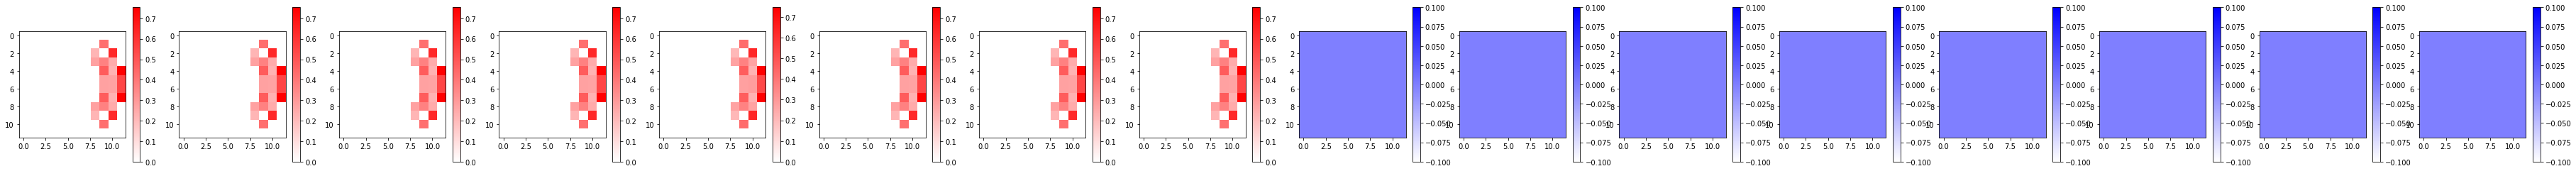

4.413063
0.0


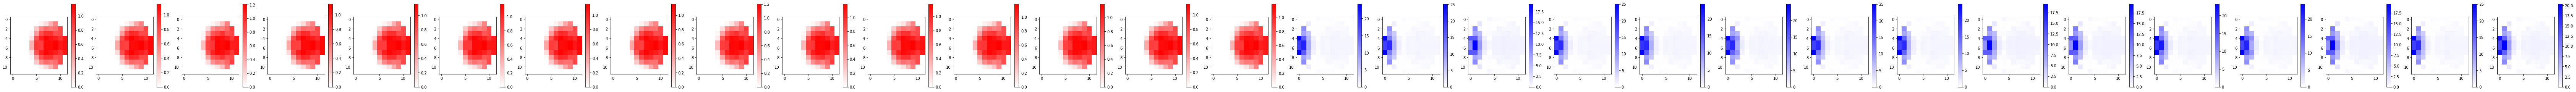

43.861015
3942.0044


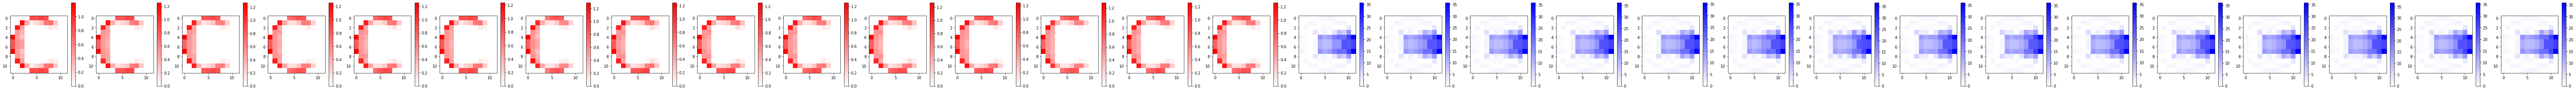

20.228966
13397.291


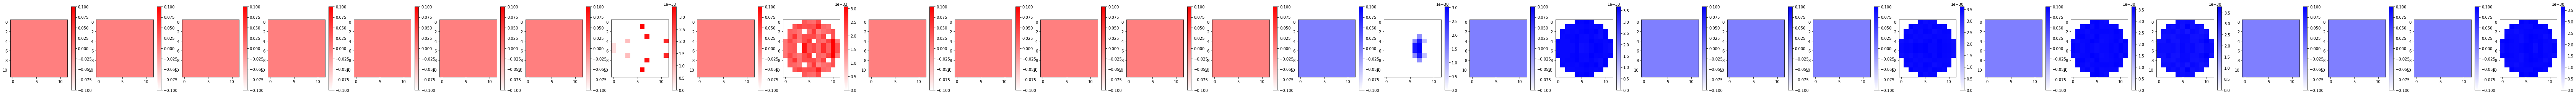

0.0
0.0


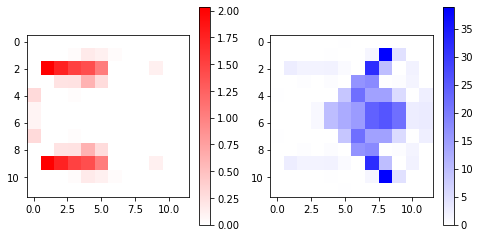

26.492554
13063.346


In [65]:
importlib.reload(hpfnbz)

K = 12
mask_d = opsg.get_disk_mask(12,4)
colormap_e = LinearSegmentedColormap.from_list('wr',['w', 'r'], N=256)
colormap_i = LinearSegmentedColormap.from_list('wb',['w', 'b'], N=256)
for label in range(1,NC+1):
    sample_array = np.where(C==label)[0]
    sample_list = list(sample_array[:15])
    fig = hpfnbz.display_weights(K,trained_weights_e_all,trained_weights_i_all,sample_list,mask_d,colormap_e,colormap_i)
    fig.savefig(savepath+'weight_{}.png'.format(label))
    
    trained_weights_e = trained_weights_e_all[sample_array[0],:].reshape((K,K))
    trained_weights_i = trained_weights_i_all[sample_array[0],:].reshape((K,K))
    trained_weights_e[mask_d] = 0.
    trained_weights_i[mask_d] = 0.
    print((trained_weights_e**2).sum())
    print((trained_weights_i**2).sum())

In [66]:
color_dict = {}
color_dict[1] = 'k' # no structure
color_dict[4] = 'k' # no structure
color_dict[5] = 'k' # no structure
color_dict[2] = 'r' # normal
color_dict[3] = 'm' # reversed

color_list = [color_dict[ii] for ii in list(C)]

N = 100
labels = np.zeros(N)
labels[:] = C[:]
N_samples = np.zeros(NC)
for ii in range(NC):
    N_samples[ii] = np.where(labels==ii+1)[0].shape[0]
    print(N_samples[ii])
inds_sort = np.argsort(labels)

label_color_dendro = {}
for ii in range(N):
    label_color_dendro[str(ii)] = color_dict[labels[ii]]

8.0
37.0
16.0
38.0
1.0


In [68]:
np.where(labels==5)[0]

array([27])

[0.03074939 0.03026657 0.02873587 0.02831493 0.02706692]


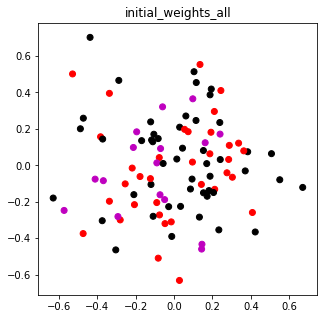

In [52]:
%matplotlib inline

pca = PCA()
initial_weights_all_pca = pca.fit_transform(initial_weights_all)
print(pca.explained_variance_ratio_[:5])

fig = plt.figure(figsize=(5,5))
plt.scatter(initial_weights_all_pca[:,0],initial_weights_all_pca[:,1],c=color_list,marker='o')
plt.title('initial_weights_all')
plt.show()
fig.savefig(savepath+'initial_weights_pca.png')

[6.8794757e-01 2.9578874e-01 1.5426538e-02 3.7372924e-04 1.5535619e-04]


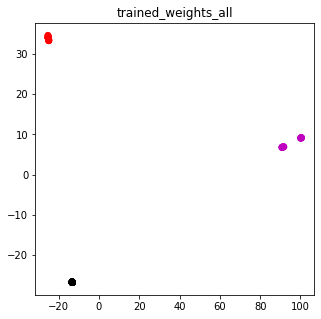

In [53]:
%matplotlib inline

pca = PCA()
trained_weights_all_pca = pca.fit_transform(trained_weights_all)
print(pca.explained_variance_ratio_[:5])

fig = plt.figure(figsize=(5,5))
plt.scatter(trained_weights_all_pca[:,0],trained_weights_all_pca[:,1],c=color_list,marker='o')
plt.title('trained_weights_all')
plt.show()
fig.savefig(savepath+'trained_weights_pca.png')

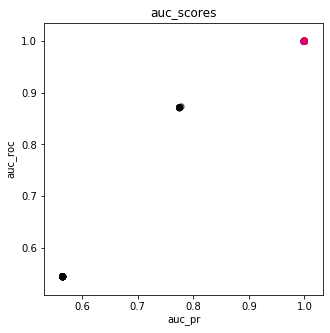

In [54]:
%matplotlib inline
fig = plt.figure(figsize=(5,5))
plt.scatter(auc_scores[:,0],auc_scores[:,1],c=color_list,marker='o',alpha=0.5)
plt.xlabel('auc_pr')
plt.ylabel('auc_roc')
plt.title('auc_scores')
plt.show()
fig.savefig(savepath+'auc_scores.png')

0.83683556


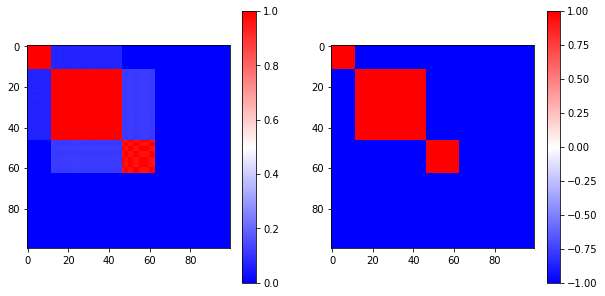

In [55]:
N = 100
cdistance = np.zeros((N,N))
cdistance_init = np.zeros((N,N))
cdistance = cosine_similarity(trained_weights_all[inds_sort[:],:],trained_weights_all[inds_sort[:],:])
cdistance_init = cosine_similarity(initial_weights_all[inds_sort[:],:],initial_weights_all[inds_sort[:],:])

mean_init = cdistance_init.mean()
print(mean_init)
cdistance_shifted = cdistance-mean_init
cdistance_shifted_signed = np.sign(cdistance_shifted)

fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(cdistance,cmap = 'bwr')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(cdistance_shifted_signed,cmap = 'bwr')
plt.colorbar()
plt.show()
fig.savefig(savepath+'trained_weights_similarity.png')

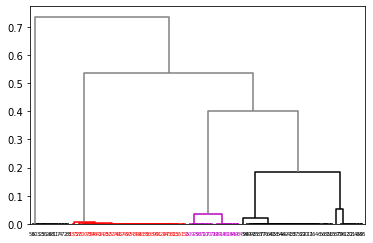

In [57]:
trained_weights_all_s = np.zeros_like(trained_weights_all)
for ii in range(trained_weights_all.shape[0]):
    trained_weights_all_s[ii,:] = trained_weights_all[ii,:]+1e-30

threshold = 0.2
Z = hierarchy.linkage(trained_weights_all_s[:,:],metric='cosine')
C = hierarchy.fcluster(Z, threshold, criterion="distance")
fig = plt.figure()
hierarchy.set_link_color_palette(['k','r','m','k'])
dn = hierarchy.dendrogram(Z,color_threshold=0.2,above_threshold_color='grey')

ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
#     lbl.set_text('o')
    lbl.set_color(label_color_dendro[lbl.get_text()])
    lbl.set_rotation('horizontal')
plt.show()
fig.savefig(savepath+'trained_weights_dendrogram.png')

(24,)
0.679 0.023
(17,)
0.462 0.105
(19,)
0.338 0.089
(39,)
0.693 0.001
(1,)
0.693 0.001


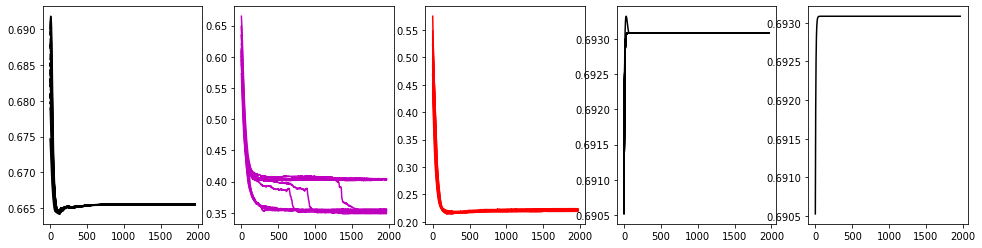

In [254]:
loss_final = []
width = 1
fig = plt.figure(figsize=(20,4))
for label in range(1,NC+1):
    sample_array = np.where(labels==label)[0]
    print(sample_array.shape)
    sample_list = list(sample_array)
    loss_tem = []
    for ii in sample_list:
        loss_tem.extend(list(loss_output_all[ii,-100:]))
    loss_final.append(loss_tem)
    loss_mean = np.round(np.mean(loss_tem),3)
    loss_std = np.round(np.std(loss_tem),3)
    print(loss_mean,loss_std)
    
    plt.subplot(1,NC+1,label+1)
    for ii in sample_list:
#         loss_output = get_running_mean_discrete(loss_output_all[ii,::1],width)
        plt.plot(loss_output_all[ii,5001::150],c=color_dict[label])
#     plt.ylim([10e-3,5*10e2])
#     plt.title('Last 100: {:.3}+/-{:.3}'.format(loss_mean,loss_std))
#     plt.yscale('log')
plt.show()
fig.savefig(savepath+'loss_fun.png')

(24,)
-0.0 2.134
(17,)
1.077 6.124
(19,)
0.423 8.026
(39,)
-0.0 0.0
(1,)
0.0 0.0


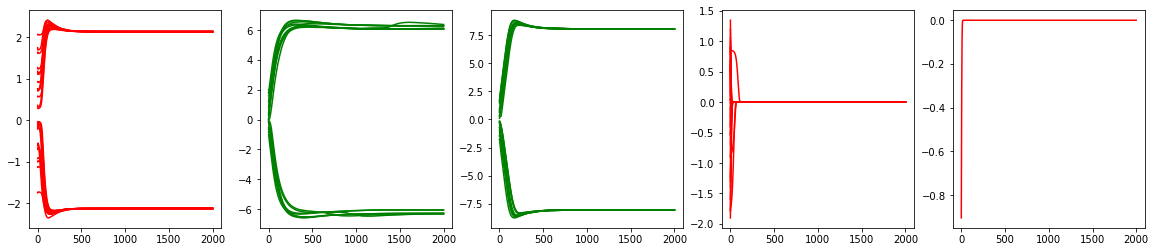

In [255]:
a_final = []
width = 1
fig = plt.figure(figsize=(20,4))
for label in range(1,NC+1):
    sample_array = np.where(labels==label)[0]
    print(sample_array.shape)
    sample_list = list(sample_array)
    a_tem = []
    for ii in sample_list:
        a_tem.extend(list(a_output_all[ii,-100:]))
    a_final.append(a_tem)
    a_mean = np.round(np.mean(a_tem),3)
    a_std = np.round(np.std(a_tem),3)
    print(a_mean,a_std)
    
    plt.subplot(1,NC,label)
    for ii in sample_list:
        if loss_output_all[ii,::150].mean() >= 0.4:
            ccc = 'r'
        else:
            ccc = 'g'
#         a_output = get_running_mean_discrete(a_output_all[ii,::1],width)
        plt.plot(a_output_all[ii,::150],c=ccc)
#     plt.ylim([10e-3,5*10e2])
#     plt.title('Last 100: {:.3}+/-{:.3}'.format(a_mean,a_std))
#     plt.yscale('log')
plt.show()
fig.savefig(savepath+'a_fun.png')

(0,)
nan nan
(24,)
-0.108 0.002
(17,)
-1.82 0.011


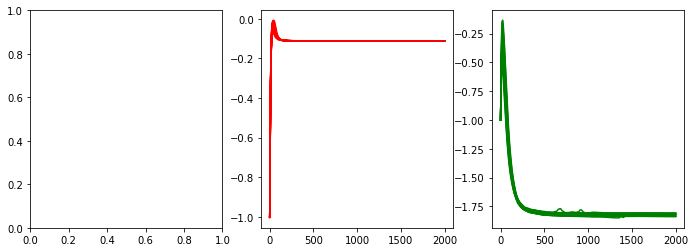

In [256]:
b_final = []
width = 1
fig = plt.figure(figsize=(20,4))
for label in range(3):
    sample_array = np.where(labels==label)[0]
    print(sample_array.shape)
    sample_list = list(sample_array)
    b_tem = []
    for ii in sample_list:
        b_tem.extend(list(b_output_all[ii,-100:]))
    b_final.append(b_tem)
    b_mean = np.round(np.mean(b_tem),3)
    b_std = np.round(np.std(b_tem),3)
    print(b_mean,b_std)
    
    plt.subplot(1,5,label+1)
    for ii in sample_list:
#         b_output = get_running_mean_discrete(b_output_all[ii,::1],width)
        if loss_output_all[ii,::150].mean() >= 0.4:
            ccc = 'r'
        else:
            ccc = 'g'
        plt.plot(b_output_all[ii,::150],c=ccc)
#     plt.ylim([10e-3,5*10e2])
#     plt.title('Last 100: {:.3}+/-{:.3}'.format(b_mean,b_std))
#     plt.yscale('log')
plt.show()
fig.savefig(savepath+'b_fun.png')

(200, 288)
0.8368356


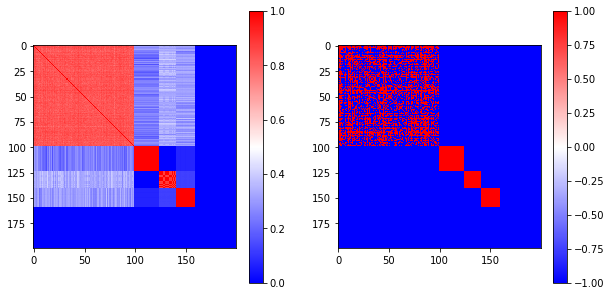

In [257]:
weights_combined = np.concatenate((initial_weights_all,trained_weights_all[inds_sort[:],:]))
print(weights_combined.shape)

N = 1000
cdistance_combined = np.zeros((N,N))
cdistance_combined = cosine_similarity(weights_combined,weights_combined)

mean_init = cdistance_init.mean()
print(mean_init)
cdistance_combined_shifted = cdistance_combined-mean_init
cdistance_combined_shifted_signed = np.sign(cdistance_combined_shifted)

fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(cdistance_combined,cmap = 'bwr')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(cdistance_combined_shifted_signed,cmap = 'bwr')
plt.colorbar()
plt.show()

# AUC score

In [335]:
importlib.reload(hpfnbz)

# model
args = {}
args["n"] = 0
args["dt"] = 0.1
args["use_intensity"] = False
args["symmetrize"] = True
args['K'] = 12
args['alpha_leak'] = 0.0
args['Q'] = 169

model_types = ['excitatory','excitatory_WNR', 'inhibitory1', 'inhibitory2']

args['temporal_filter'] = False
args['tau_1'] = 1.

set_number = 1169
data_path = '/Volumes/Baohua/data_on_hd/loom/multi_lplc2_new_fast_rot_L4_list_4/'.format(set_number)
data_types = ['hit','miss','retreat','rotation']

fpr_all = []
tpr_all = []
thres_roc_all = []
roc_auc_all = []
precision_all = []
recall_all = []
thres_pr_all = []
pr_auc_all = []
labels_1 = []
for ind,subdir in enumerate(subdir_all):
    if ind%10 == 0:
        if os.path.exists(subdir+'/trained_weights_e.npy'):
            print(ind)
            model_path = subdir+'/'
            model_type = model_types[3]
            data_type = data_types[0]
            prob_hit = hpfnbz.get_probability2(args,model_path,model_type,data_path,set_number,data_type)
            model_type = model_types[3]
            data_type = data_types[1]
            prob_miss = hpfnbz.get_probability2(args,model_path,model_type,data_path,set_number,data_type)
            model_type = model_types[3]
            data_type = data_types[2]
            prob_retreat = hpfnbz.get_probability2(args,model_path,model_type,data_path,set_number,data_type)
            model_type = model_types[3]
            data_type = data_types[3]
            prob_rot = hpfnbz.get_probability2(args,model_path,model_type,data_path,set_number,data_type)

            y_scores = np.concatenate((prob_hit,prob_miss,prob_retreat,prob_rot))
            y_labels = np.zeros(len(y_scores))
            y_labels[:len(prob_hit)] = 1
            fpr, tpr, thresholds_roc = metrics.roc_curve(y_labels, y_scores)
            precision, recall, thresholds_pr = metrics.precision_recall_curve(y_labels, y_scores)
            roc_auc = metrics.roc_auc_score(y_labels,y_scores)
            pr_auc = metrics.average_precision_score(y_labels,y_scores)

            fpr_all.append(fpr)
            tpr_all.append(tpr)
            thres_roc_all.append(thresholds_roc)
            roc_auc_all.append(roc_auc)

            precision_all.append(precision)
            recall_all.append(recall)
            thres_pr_all.append(thresholds_pr)
            pr_auc_all.append(pr_auc)

            labels_1.append(labels[ind])


0


KeyboardInterrupt: 

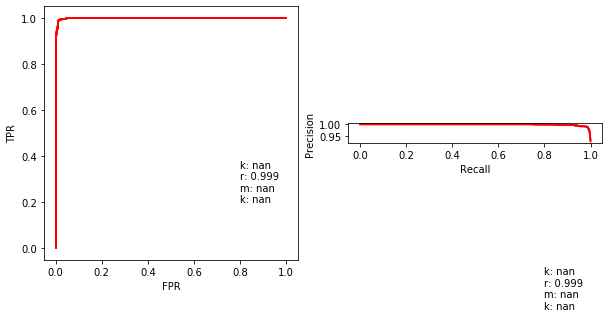

In [334]:
ypos = [0.35,0.3,0.25,0.2]
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
for label,fpr,tpr in zip(labels_1,fpr_all,tpr_all):
    plt.plot(fpr,tpr,c=color_dict[np.int(label)])
for ii in range(4):
    auc = np.mean(np.array(roc_auc_all)[(np.array(labels_1)==ii+1)])
    plt.text(0.8,ypos[ii],color_dict[ii+1]+': '+str(np.round(auc,3)))
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.axis('scaled')
plt.subplot(1,2,2)
for label,precision,recall in zip(labels_1,precision_all,recall_all):
    plt.plot(recall,precision,c=color_dict[np.int(label)])
for ii in range(4):
    auc = np.mean(np.array(pr_auc_all)[(np.array(labels_1)==ii+1)])
    plt.text(0.8,ypos[ii],color_dict[ii+1]+': '+str(np.round(auc,3)))
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.axis('scaled')
plt.show()
fig.savefig(savepath+'auc.png')

In [192]:
importlib.reload(hpfnbz)

# model
args = {}
args["n"] = 0
args["dt"] = 0.1
args["use_intensity"] = False
args["symmetrize"] = True
args['K'] = 12
args['alpha_leak'] = 0.0
args['Q'] = 1

model_types = ['excitatory','excitatory_WNR', 'inhibitory1', 'inhibitory2']

args['temporal_filter'] = False
args['tau_1'] = 1.
model_path = '../results/test_weights_2/Q{}/'.format(args['Q'])

set_number = 1001
data_path = '/Volumes/Baohua/data_on_hd/loom/multi_lplc2_new_fast_rot_L4_list_4/'.format(set_number)
data_types = ['hit','miss','retreat','rotation']

model_type = model_types[3]
data_type = data_types[0]
prob_hit = hpfnbz.get_probability2(args,model_path+model_type+'/',model_type,data_path,set_number,data_type)
model_type = model_types[3]
data_type = data_types[1]
prob_miss = hpfnbz.get_probability2(args,model_path+model_type+'/',model_type,data_path,set_number,data_type)
model_type = model_types[3]
data_type = data_types[2]
prob_retreat = hpfnbz.get_probability2(args,model_path+model_type+'/',model_type,data_path,set_number,data_type)
model_type = model_types[3]
data_type = data_types[3]
prob_nat = hpfnbz.get_probability2(args,model_path+model_type+'/',model_type,data_path,set_number,data_type)

y_scores = np.concatenate((prob_hit,prob_miss,prob_retreat,prob_nat))
y_labels = np.zeros(len(y_scores))
y_labels[:len(prob_hit)] = 1

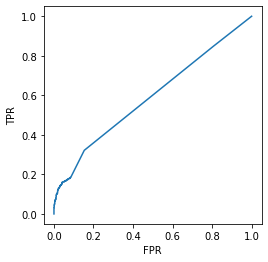

In [193]:
fpr, tpr, thresholds = metrics.roc_curve(y_labels, y_scores)

plt.plot(fpr,tpr)
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.axis('scaled')
plt.show()

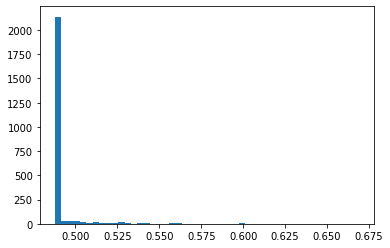

In [194]:
plt.hist(y_scores,np.int(np.sqrt(len(y_scores))))
plt.show()

In [195]:
print(metrics.roc_auc_score(y_labels,y_scores))
print(metrics.average_precision_score(y_labels,y_scores))

precision, recall, thresholds = metrics.precision_recall_curve(y_labels,y_scores)
auc_pr = metrics.auc(recall, precision)
print(auc_pr)

0.5902423611111111
0.6014509934621038
0.6462306629658029


In [196]:
metrics.confusion_matrix(y_labels,np.round(y_scores))

array([[1164,   36],
       [1033,  167]])

In [419]:
N = 400
trained_weights_e_normal = []
trained_weights_i_normal = []
roc_score = []
for nn in range(N):
    if labels[nn] == 0 or labels[nn] == 1:
        trained_weights_e_normal.append(trained_weights_e_all[nn,:])
        trained_weights_i_normal.append(trained_weights_i_all[nn,:])
        roc_score.append(auc_scores[nn,1])
trained_weights_e_normal = np.array(trained_weights_e_normal)
trained_weights_i_normal = np.array(trained_weights_i_normal)
roc_score = np.array(roc_score)

In [420]:
roc_score_ind_sorted = np.argsort(roc_score)
trained_weights_e_normal_sorted = trained_weights_e_normal[roc_score_ind_sorted,:]
trained_weights_i_normal_sorted = trained_weights_i_normal[roc_score_ind_sorted,:]

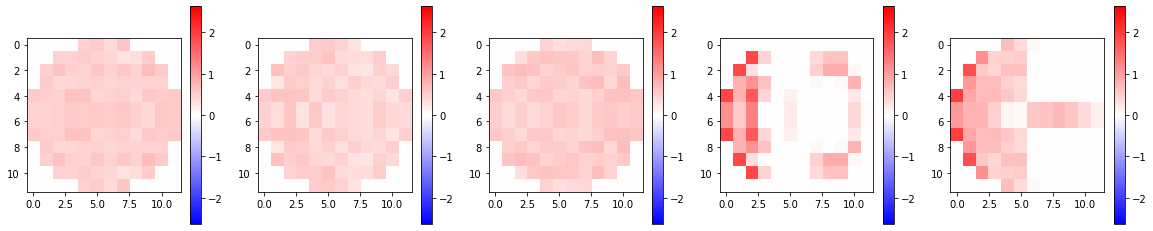

In [421]:
importlib.reload(hpfnbz)

K = 12
input_weights = trained_weights_e_normal_sorted
mask_d = opsg.get_disk_mask(12,20)
colormap = 'bwr'
M = 5

fig = hpfnbz.display_weights2(K,input_weights,mask_d,colormap,M)

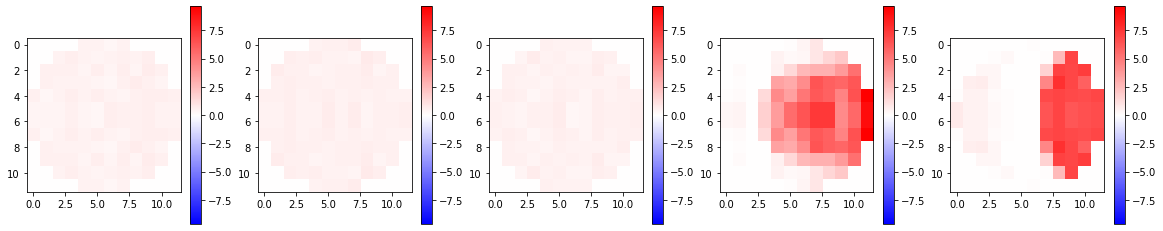

In [422]:
importlib.reload(hpfnbz)

K = 12
input_weights = trained_weights_i_normal_sorted
mask_d = opsg.get_disk_mask(12,20)
colormap = 'bwr'
M = 5

fig = hpfnbz.display_weights2(K,input_weights,mask_d,colormap,M)

In [203]:
def get_running_mean_discrete(input_array_1d,width):
    L1 = input_array_1d.shape[0]
    L2 = np.int(L1/width)
    output_array = np.zeros(L2)
    for l2 in range(L2):
        output_array[l2] = input_array_1d[l2*width:l2*width+width].mean()
        
    return output_array

(6000, 100)


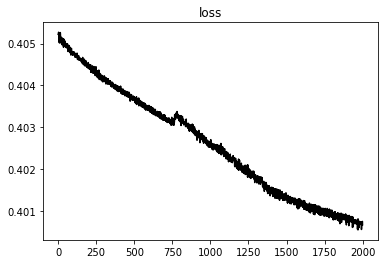

In [175]:
save_path = '/Users/bhzhou01/Google Drive/research/loom_cluster/results/\
set_2_R1.0/inhibitory2/ACT_0_0.001/True_True_20200707011333/'

loss = np.load(save_path+'loss_output.npy')
loss2 = loss.reshape((6000,-1))
print(loss2.shape)
# n = 0
# for ii in range(n,n+10):
#     plt.plot(loss2[:,ii],'.',c=[random.random(),random.random(),random.random()])
plt.plot(loss2[-2000:,:].mean(axis=1),c='k')
# plt.errorbar(np.arange(loss2.shape[0]),loss2[:,:].mean(axis=1),loss2[:,:].std(axis=1),c='k')
plt.title('loss')
plt.show()

(3000, 200)


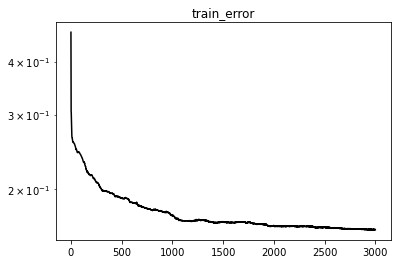

In [177]:
train_error = np.load(save_path+'train_error_output.npy')
train_error = train_error.mean(axis=1)
train_error2 = train_error.reshape((3000,-1))
print(train_error2.shape)
# n = 0
# for ii in range(n,n+100):
#     plt.plot(train_error[ii+10000::100],'.',c=[random.random(),random.random(),random.random()])
plt.plot(train_error2[:,:].mean(axis=1),c='k')
plt.yscale('log')
plt.title('train_error')
plt.show()

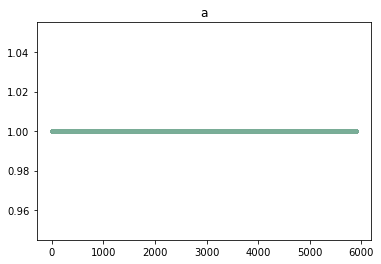

In [124]:
a = np.load(save_path+'a_output.npy')
n = 0
for ii in range(n,n+100):
    plt.plot(a[ii+10000::100],'.',c=[random.random(),random.random(),random.random()])
plt.title('a')
plt.show()

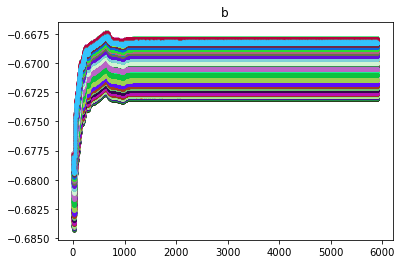

In [125]:
b = np.load(save_path+'b_output.npy')
n = 0
for ii in range(n,n+100):
    plt.plot(b[ii+10000::100],'.',c=[random.random(),random.random(),random.random()])
plt.title('b')
plt.show()

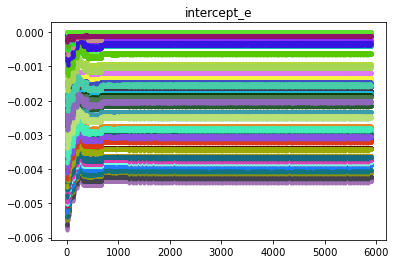

In [126]:
intercept_e = np.load(save_path+'intercept_e_output.npy')
n = 0
for ii in range(n,n+100):
    plt.plot(intercept_e[ii+10000::100],'.',c=[random.random(),random.random(),random.random()])
plt.title('intercept_e')
plt.show()

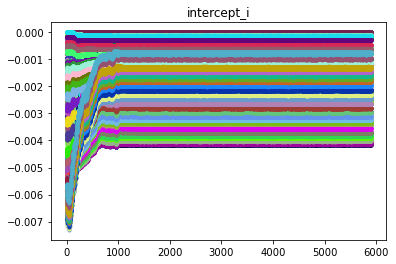

In [127]:
intercept_i = np.load(save_path+'intercept_i_output.npy')
n = 0
for ii in range(n,n+100):
    plt.plot(intercept_i[ii+10000::100],'.',c=[random.random(),random.random(),random.random()])
plt.title('intercept_i')
plt.show()

In [236]:
initial_weights_all_flattened = initial_weights_all.flatten()
initial_weights_all_flattened.shape

(57600,)

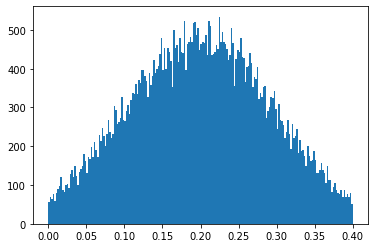

In [237]:
plt.hist(initial_weights_all_flattened,200)
plt.show()

(40320,)


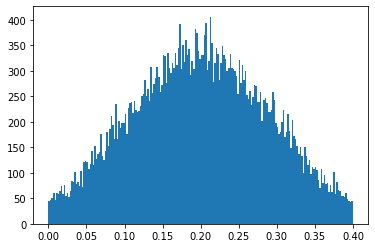

In [11]:
initial_weights_all_flattened = initial_weights_all.flatten()
print(initial_weights_all_flattened.shape)
plt.hist(initial_weights_all_flattened,200)
plt.show()

In [39]:
import difflib

file1 = '../../loom/loom2/code/lplc2_models.py'
file2 = '../../loom_cluster/code/lplc2_models.py'
with open(file1) as f1:
    f1_text = f1.read()
with open(file2) as f2:
    f2_text = f2.read()
# Find and print the diff:
for line in difflib.unified_diff(f1_text, f2_text, fromfile=file1, tofile=file2, lineterm=''):
    print(line)

--- ../../loom/loom2/code/lplc2_models.py
+++ ../../loom_cluster/code/lplc2_models.py
@@ -133,6 +133,18 @@
 r
 t
  
+m
+a
+t
+h
+

+i
+m
+p
+o
+r
+t
+ 
 t
 e
 n
@@ -243,6 +255,36 @@
 n
 3
 d
+

+i
+m
+p
+o
+r
+t
+ 
+o
+p
+t
+i
+c
+a
+l
+_
+s
+i
+g
+n
+a
+l
+ 
+a
+s
+ 
+o
+p
+s
+g
 

 

 

@@ -954,6 +996,7 @@
 t
 

 

+

 #
  
 I
@@ -8174,6 +8217,27 @@
  
  
  
+l
+o
+s
+s
+_
+o
+u
+t
+p
+u
+t
+ 
+=
+ 
+[
+]
+

+ 
+ 
+ 
+ 
 

  
  
@@ -11322,7 +11386,7 @@
 =
 0
 .
-1
+4
 )
 

  
@@ -13337,6 +13401,197 @@
 .
 0
 

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+

+ 
+ 
+ 
+ 
+w
+i
+t
+h
+ 
+t
+f
+.
+c
+o
+m
+p
+a
+t
+.
+v
+1
+.
+S
+e
+s
+s
+i
+o
+n
+(
+)
+ 
+a
+s
+ 
+s
+e
+s
+s
+:
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+s
+e
+s
+s
+.
+r
+u
+n
+(
+t
+f
+.
+c
+o
+m
+p
+a
+t
+.
+v
+1
+.
+g
+l
+o
+b
+a
+l
+_
+v
+a
+r
+i
+a
+b
+l
+e
+s
+_
+i
+n
+i
+t
+i
+a
+l
+i
+z
+e
+r
+(
+)
+)
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+n
+p
+.
+s
+a
+v
+e
+(
+a
+r
+g
+s
+[
+'
+s
+a
+v
+e
+_
+p
+a
+t
+h
+'
+]
+ 
++
+ 
+'
+i
+n
+i
+t
+i
+a
+l
+_

+ 
+ 
+ 
+t
+r
+a
+i
+n
+_
+e
+r
+r
+o
+r
+_
+o
+u
+t
+p
+u
+t
+ 
+=
+ 
+[
+]
+

+ 
+ 
+ 
+ 
+b
+_
+o
+u
+t
+p
+u
+t
+ 
+=
+ 
+[
+]
+

+ 
+ 
+ 
+ 
+i
+n
+t
+e
+r
+c
+e
+p
+t
+_
+e
+_
+o
+u
+t
+p
+u
+t
+ 
+=
+ 
+[
+]
+

+ 
+ 
+ 
+ 
+i
+n
+t
+e
+r
+c
+e
+p
+t
+_
+i
+_
+o
+u
+t
+p
+u
+t
+ 
+=
+ 
+[
+]
+

+ 
+ 
+ 
+ 
+l
+p
+l
+c
+2
+_
+c
+e
+l
+l
+s
+ 
+=
+ 
+o
+p
+s
+g
+.
+g
+e
+t
+_
+l
+p
+l
+c
+2
+_
+c
+e
+l
+l
+s
+_
+x
+y
+_
+a
+n
+g
+l
+e
+s
+(
+Q
+)
 

  
  
@@ -71592,28 +73604,45 @@
 e
 (
 '
-r
-e
-s
-t
-r
-i
-c
-t
-_
-n
-o
-n
-n
-e
-g
-_
-w
-e
-i
-g
-h
-t
+l
+1
+ 
+r
+e
+g
+u
+l
+a
+r
+i
+z
+a
+t
+i
+o
+n
+ 
+o
+n
+ 
+e
+x
+c
+i
+t
+a
+t
+o
+r
+y
+ 
+w
+e
+i
+g
+h
+t
+s
 :
  
 {
@@ -71629,47 +73658,22 @@
 a
 t
 (
-

- 
- 
- 
- 
- 
- 
- 
- 
- 
- 
- 
- 
 a
 r
 g
 s
 [
 '
-r
-e
-s
-t
-r
-i
-c
-t
-_
-n
-o
-n
-n
-e
-g
-_
-w
-e
-i
-g
-h
-t
+l
+1
+_
+r
+e
+g
+u
+_
+w
+e
 '
 ]
 )
@@ -71692,31 +73696,45 @@
 e
 (
 '
-r
-e
-s
-t
-r
-i
-c
-t
-_
-n
-o
-n
-p
-o
-s
-_
-i
-n
-t
-e
-r
-c
-e
-p
-t
+

+U
+V
+_
+f
+l
+o
+w
+_
+i
+,
+l
+p
+l
+c
+2
+_
+c
+e
+l
+l
+s
+)
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
 _
 ,
  
@@ -79116,66 +82826,6 @@
 i
 ,
  
-f
-r
-a
-m
-e
-_
-i
-n
-t
-e
-n
-s
-i
-t
-y
-:
- 
-f
-r
-a
-m
-e
-_
-i
-n
-t
-e
-n
-s
-i
-t
-y
-_
-i
-,
-

- 
- 
- 
- 
- 
- 
- 
- 
- 
- 
- 
- 
- 
- 
- 
- 
- 
- 
- 
- 
- 
- 
- 
- 
 s
 t
 e
@@ -79316,8 +82966,61 @@
 w
 _
 i
- 
-=
+,
+s
+t
+e
+p
+_
+w
+e
+i
+g
+h
+t
+s
+_
+i
+,
+l
+a
+b
+e
+l
+s
+_
+i
+ 
+=
+\
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
  
 l
 o
@@ -79363,6 +83066,15 @@
 e
 _
 i
+,
+l
+a
+b
+e
+l
+s
+_
+i
 )
 

  
@@ -79424,8 +83136,61 @@
 w
 _
 i
- 
-=
+,
+s
+t
+e
+p
+_
+w
+e
+i
+g
+h
+t
+s
+_
+i
+,
+l
+a
+b
+e
+l
+s
+_
+i
+ 
+=
+\
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
  
 l
 o
@@ -79469,6 +83234,15 @@
 i
 l
 e
+_
+i
+,
+l
+a
+b
+e
+l
+s
 _
 i
 )
@@ -79521,6 +83295,78 @@
  
  
  
+U
+V
+_
+f
+l
+o
+w
+_
+i
+ 
+=
+ 
+

+t
+a
+s
+e
+t
+(
+a
+r
+g
+s
+,
+ 
+U
+V
+_
+f
+l
+o
+w
+_
+f
+i
+l
+e
+_
+i
+,
+l
+a
+b
+e
+l
+s
+_
+i
+)
+[
+:
+-
+a
+r
+g
+s
+[
+'
+f
+r
+a
+m
+e
+s
+_
+t
+o
+_
+r
+e
+m
+o
+v
+e
+'
+]
+]
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+U
+V
+_
+f
+l
+o
+w
+_
+i
+ 
+=
+ 
+s
+w
+i
+t
+c
+h
+_
+x
+_
+U
+V
+_
+f
+l
+o
+w
+(
+U
+V
+_
+f
+l
+o
+w
+_
+i
+,
+l
+p
+l
+c
+2
+_
+c
+e
+l
+l
+s
+)
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+l
+o
+s
+s
+_
+i
+,
+ 
+e
+r
+r
+o
+r
+_
+s
+t
+e
+p
+_
+i
+,
+ 
+e
+r
+r
+o
+r
+_
+t
+r
+a
+j
+e
+c
+t
+o
+r
+y
+_
+i
+,
+ 
+p
+r
+o
+b
+a
+b
+i
+l
+i
+t
+i
+e
+s
+_
+i
+ 
+=
+ 
+\
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+s
+e
+s
+s
+.
+r
+u
+n
+(
+[
+l
+o
+s
+s
+,
+ 
+e
+r
+r
+o
+r
+_
+s
+t
+e
+p
+,
+ 
+e
+r
+r
+o
+r
+_
+t
+r
+a
+j
+e
+c
+t
+o
+r
+y
+,
+ 
+p
+r
+o
+b
+a
+b
+i
+l
+i
+t
+i
+e
+s
+]
+,
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+{
+U
+V
+_
+f
+l
+o
+w
+:
+U
+V
+_
+f
+l
+o
+w
+_
+i
+,
+ 
+l
+a
+b
+e
+

+t
+r
+a
+i
+n
+_
+e
+r
+r
+o
+r
+_
+o
+u
+t
+p
+u
+t
+'
+,
+ 
+t
+r
+a
+i
+n
+_
+e
+r
+r
+o
+r
+_
+o
+u
+t
+p
+u
+t
+)
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+n
+p
+.
+s
+a
+v
+e
+(
+a
+r
+g
+s
+[
+'
+s
+a
+v
+e
+_
+p
+a
+t
+h
+'
+]
+ 
++
+ 
+'
+b
+_
+o
+u
+t
+p
+u
+t
+'
+,
+ 
+b
+_
+o
+u
+t
+p
+u
+t
+)
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+n
+p
+.
+s
+a
+v
+e
+(
+a
+r
+g
+s
+[
+'
+s
+a
+v
+e
+_
+p
+a
+t
+h
+'
+]
+ 
++
+ 
+'
+i
+n
+t
+e
+r
+c
+e
+p
+t
+_
+e
+_
+o
+u
+t
+p
+u
+t
+'
+,
+ 
+i
+n
+t
+e
+r
+c
+e
+p
+t
+_
+e
+_
+o
+u
+t
+p
+u
+t
+)
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+n
+p
+.
+s
+a
+v
+e
+(
+a
+r
+g
+s
+[
+'
+s
+a
+v
+e
+_
+p
+a
+t
+h
+'
+]
+ 
++
+ 
+'
+i
+n
+t
+e
+r
+c
+e
+p
+t
+_
+i
+_
+o
+u
+t
+p
+u
+t
+'
+,
+ 
+i
+n
+t
+e
+r
+c
+e
+p
+t
+_
+i
+_
+o
+u
+t
+p
+u
+t
+)
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+n
+p
+.
+s
+a
+v
+e
+(
+a
+r
+g
+s
+[
+'
+s
+a
+v
+e
+_
+p
+a
+t
+h
+'
+]
+ 
++
+ 
+'
+a
+u
+c
+_
+r
+o
+c
+'
+,
+ 
+a
+u
+c
+_
+r
+o
+c
+)
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+n
+p
+.
+s
+a
+v
+e
+(
+a
+r
+g
+s
+[
+'
+

+_
+i
+n
+p
+u
+t
+ 
+=
+ 
+n
+p
+.
+l
+o
+a
+d
+(
+m
+o
+d
+e
+l
+_
+p
+a
+t
+h
+ 
++
+ 
+"
+t
+r
+a
+i
+n
+e
+d
+_
+w
+e
+i
+g
+h
+t
+s
+_
+e
+.
+n
+p
+y
+"
+)
+

+ 
+ 
+ 
+ 
+w
+e
+i
+g
+h
+t
+s
+_
+i
+_
+i
+n
+p
+u
+t
+ 
+=
+ 
+n
+p
+.
+l
+o
+a
+d
+(
+m
+o
+d
+e
+l
+_
+p
+a
+t
+h
+ 
++
+ 
+"
+t
+r
+a
+i
+n
+e
+d
+_
+w
+e
+i
+g
+h
+t
+s
+_
+i
+.
+n
+p
+y
+"
+)
+

+ 
+ 
+ 
+ 
+i
+n
+t
+e
+r
+c
+e
+p
+t
+_
+i
+_
+i
+n
+p
+u
+t
+ 
+=
+ 
+n
+p
+.
+l
+o
+a
+d
+(
+m
+o
+d
+e
+l
+_
+p
+a
+t
+h
+ 
++
+ 
+"
+t
+r
+a
+i
+n
+e
+d
+_
+i
+n
+t
+e
+r
+c
+e
+p
+t
+_
+i
+.
+n
+p
+y
+"
+)
+

+

+ 
+ 
+ 
+ 
+#
+ 
+v
+a
+r
+i
+a
+b
+l
+e
+s
+

+ 
+ 
+ 
+ 
+w
+i
+t
+h
+ 
+t
+f
+.
+c
+o
+m
+p
+a
+t
+.
+v
+1
+.
+v
+a
+r
+i
+a
+b
+l
+e
+_
+s
+c
+o
+p
+e
+(
+'
+i
+n
+h
+i
+b
+i
+t
+o
+r
+y
+_
+2
+'
+)
+:
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+i
+n
+i
+t
+i
+a
+l
+i
+z
+e
+r
+ 
+=
+ 
+t
+f
+.
+c
+o
+m
+p
+a
+t
+.
+v
+1
+.
+k
+e
+r
+a
+s
+.
+i
+n
+i
+t
+i
+a
+l
+i
+z
+e
+r
+s
+.
+V
+a
+r
+i
+a
+n
+c
+e
+S
+c
+a
+l
+i
+

+ 
+ 
+ 
+#
+ 
+R
+e
+g
+u
+l
+a
+r
+i
+z
+a
+t
+i
+o
+n
+

+ 
+ 
+ 
+ 
+l
+1
+_
+l
+2
+_
+r
+e
+g
+u
+_
+w
+e
+ 
+=
+ 
+t
+f
+.
+c
+o
+n
+t
+r
+i
+b
+.
+l
+a
+y
+e
+r
+s
+.
+l
+1
+_
+l
+2
+_
+r
+e
+g
+u
+l
+a
+r
+i
+z
+e
+r
+(
+s
+c
+a
+l
+e
+_
+l
+1
+=
+a
+r
+g
+s
+[
+"
+l
+1
+_
+r
+e
+g
+u
+_
+w
+e
+"
+]
+,
+s
+c
+a
+l
+e
+_
+l
+2
+=
+a
+r
+g
+s
+[
+"
+l
+2
+_
+r
+e
+g
+u
+_
+w
+e
+"
+]
+,
+s
+c
+o
+p
+e
+=
+N
+o
+n
+e
+)
+

+ 
+ 
+ 
+ 
+l
+1
+_
+l
+2
+_
+r
+e
+g
+u
+_
+w
+i
+ 
+=
+ 
+t
+f
+.
+c
+o
+n
+t
+r
+i
+b
+.
+l
+a
+y
+e
+r
+s
+.
+l
+1
+_
+l
+2
+_
+r
+e
+g
+u
+l
+a
+r
+i
+z
+e
+r
+(
+s
+c
+a
+l
+e
+_
+l
+1
+=
+a
+r
+g
+s
+[
+"
+l
+1
+_
+r
+e
+g
+u
+_
+w
+i
+"
+]
+,
+s
+c
+a
+l
+e
+_
+l
+2
+=
+a
+r
+g
+s
+[
+"
+l
+2
+_
+r
+e
+g
+u
+_
+w
+i
+"
+]
+,
+s
+c
+o
+p
+e
+=
+N
+o
+n
+e
+)
+

+ 
+ 
+ 
+ 
+l
+1
+_
+l
+2
+_
+r
+e
+g
+u
+_
+a
+ 
+=
+ 
+t
+f
+.
+c
+o
+n
+t
+r
+i
+b
+.
+l
+a
+y
+e
+r
+s
+.
+l
+1
+_
+l
+2
+_
+r
+e
+g
+u
+l
+a
+r
+i
+z
+e
+r
+(
+s
+c
+a
+l
+e
+_
+l
+1
+=
+a
+

+l
+a
+b
+e
+l
+s
+_
+i
+ 
+=
+\
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+l
+o
+a
+d
+_
+c
+o
+m
+p
+r
+e
+s
+s
+e
+d
+_
+d
+a
+t
+a
+s
+e
+t
+(
+a
+r
+g
+s
+,
+ 
+U
+V
+_
+f
+l
+o
+w
+_
+f
+i
+l
+e
+_
+i
+,
+l
+a
+b
+e
+l
+s
+_
+i
+)
+[
+:
+-
+a
+r
+g
+s
+[
+'
+f
+r
+a
+m
+e
+s
+_
+t
+o
+_
+r
+e
+m
+o
+v
+e
+'
+]
+]
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+U
+V
+_
+f
+l
+o
+w
+_
+i
+ 
+=
+ 
+s
+w
+i
+t
+c
+h
+_
+x
+_
+U
+V
+_
+f
+l
+o
+w
+(
+U
+V
+_
+f
+l
+o
+w
+_
+i
+,
+l
+p
+l
+c
+2
+_
+c
+e
+l
+l
+s
+)
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+l
+o
+s
+s
+_
+i
+,
+ 
+e
+r
+r
+o
+r
+_
+s
+t
+e
+p
+_
+i
+,
+ 
+e
+r
+r
+o
+r
+_
+t
+r
+a
+j
+e
+c
+t
+o
+r
+y
+_
+i
+,
+ 
+p
+r
+o
+b
+a
+b
+i
+l
+i
+t
+i
+e
+s
+_
+i
+ 
+=
+ 
+\
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+s
+e
+s
+s
+.
+r
+u
+n
+(
+[
+l
+o
+s
+s
+,
+ 
+e
+r
+r
+o
+r
+_
+s
+t
+e
+p
+,
+ 
+e
+r
+r
+o
+r
+_
+t
+r
+a
+j
+e
+c
+t
+o
+r
+y
+,
+ 
+p
+r
+o
+b
+a
+b
+

+u
+t
+p
+u
+t
+ 
+=
+ 
+[
+]
+

+ 
+ 
+ 
+ 
+i
+n
+t
+e
+r
+c
+e
+p
+t
+_
+e
+_
+o
+u
+t
+p
+u
+t
+ 
+=
+ 
+[
+]
+

+ 
+ 
+ 
+ 
+i
+n
+t
+e
+r
+c
+e
+p
+t
+_
+i
+_
+o
+u
+t
+p
+u
+t
+ 
+=
+ 
+[
+]
+

+ 
+ 
+ 
+ 
+l
+p
+l
+c
+2
+_
+c
+e
+l
+l
+s
+ 
+=
+ 
+o
+p
+s
+g
+.
+g
+e
+t
+_
+l
+p
+l
+c
+2
+_
+c
+e
+l
+l
+s
+_
+x
+y
+_
+a
+n
+g
+l
+e
+s
+(
+Q
+)
+

+ 
+ 
+ 
+ 
+

+ 
+ 
+ 
+ 
+w
+i
+t
+h
+ 
+o
+p
+e
+n
+(
+l
+o
+g
+_
+f
+i
+l
+e
+,
+ 
+'
+w
+'
+)
+ 
+a
+s
+ 
+f
+:
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+f
+.
+w
+r
+i
+t
+e
+(
+'
+M
+o
+d
+e
+l
+ 
+s
+e
+t
+u
+p
+:
+\
+n
+'
+)
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+f
+.
+w
+r
+i
+t
+e
+(
+'
+-
+-
+-
+-
+-
+-
+-
+-
+-
+-
+-
+-
+-
+-
+-
+-
+-
+-
+-
+-
+-
+-
+-
+-
+-
+-
+-
+-
+-
+-
+-
+-
+-
+-
+-
+-
+-
+-
+-
+-
+\
+n
+'
+)
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+f
+.
+w
+r
+i
+t
+e
+(
+'
+M
+o
+d
+e
+l
+ 
+i
+s
+ 
+i
+n
+h
+i
+b
+i
+t
+o
+r
+y
+2
+ 
+\
+n
+'
+)
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+f
+.
+w
+r
+i
+t
+e
+(
+'
+s
+e
+t
+_
+n
+u
+m
+b
+e
+r
+:
+ 
+{
+}
+\
+n
+'
+.
+

+u
+n
+d
+(
+n
+p
+.
+e
+x
+p
+(
+-
+a
+r
+g
+s
+[
+'
+t
+a
+u
+'
+]
+)
+,
+ 
+3
+)
+)
+ 
++
+ 
+'
+\
+n
+\
+n
+'
+)
+

+ 
+ 
+ 
+ 
+

+ 
+ 
+ 
+ 
+N
+_
+t
+r
+a
+i
+n
+ 
+=
+ 
+l
+e
+n
+(
+t
+r
+a
+i
+n
+_
+f
+l
+o
+w
+_
+f
+i
+l
+e
+s
+)
+

+ 
+ 
+ 
+ 
+N
+_
+t
+e
+s
+t
+ 
+=
+ 
+l
+e
+n
+(
+t
+e
+s
+t
+_
+f
+l
+o
+w
+_
+f
+i
+l
+e
+s
+)
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+

+ 
+ 
+ 
+ 
+#
+ 
+i
+n
+p
+u
+t
+s
+

+ 
+ 
+ 
+ 
+U
+V
+_
+f
+l
+o
+w
+ 
+=
+ 
+t
+f
+.
+c
+o
+m
+p
+a
+t
+.
+v
+1
+.
+p
+l
+a
+c
+e
+h
+o
+l
+d
+e
+r
+(
+t
+f
+.
+f
+l
+o
+a
+t
+3
+2
+,
+ 
+[
+N
+o
+n
+e
+,
+N
+o
+n
+e
+,
+Q
+,
+K
+*
+K
+,
+4
+]
+,
+ 
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+n
+a
+m
+e
+ 
+=
+ 
+'
+U
+V
+_
+f
+l
+o
+w
+'
+)
+

+ 
+ 
+ 
+ 
+s
+t
+e
+p
+_
+w
+e
+i
+g
+h
+t
+s
+ 
+=
+ 
+t
+f
+.
+c
+o
+m
+p
+a
+t
+.
+v
+1
+.
+p
+l
+a
+c
+e
+h
+o
+l
+d
+e
+r
+(
+t
+f
+.
+f
+l
+o
+a
+t
+3
+2
+,
+ 
+[
+N
+o
+n
+e
+,
+N
+o
+n
+e
+]
+,
+ 
+n
+a
+m
+e
+=
+'
+s
+t
+e
+p
+_
+w
+e
+i
+g
+h
+t
+s
+'
+)
+

+ 
+ 
+ 
+ 
+l
+a
+b
+

+ 
+ 
+ 
+ 
+ 
+i
+n
+t
+e
+r
+c
+e
+p
+t
+_
+e
+ 
+=
+ 
+t
+f
+.
+V
+a
+r
+i
+a
+b
+l
+e
+(
+i
+n
+i
+t
+i
+a
+l
+_
+v
+a
+l
+u
+e
+=
+s
+a
+v
+e
+d
+_
+i
+n
+t
+e
+r
+c
+e
+p
+t
+_
+e
+,
+ 
+n
+a
+m
+e
+=
+'
+n
+t
+e
+r
+c
+e
+p
+t
+_
+e
+'
+)
+

+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+s
+a
+v
+e
+d
+_
+i
+n
+t
+e
+r
+c
+e
+p
+t
+_
+i
+ 
+=
+ 
+n
+p
+.
+f
+l
+o
+a
+t
+3
+2
+(
+n
+p
+.
+l
+o
+a
+d
+(
+a
+r
+g
+s
+[
+'
+f
+i
+n
+e
+_
+t
+u
+n
+e
+_
+m
+o
+d
+e
+l
+_
+d
+i
+r
+'
+]
+ 
++
+ 
+'
+t
+r
+a
+i
+n
+e
+d
+_
+i
+n
+t
+e
+r
+c
+e
+p
+t
+_
+i
+.
+n
+p
+y
+'
+)
+)
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+i
+n
+t
+e
+r
+c
+e
+p
+t
+_
+i
+ 
+=
+ 
+t
+f
+.
+V
+a
+r
+i
+a
+b
+l
+e
+(
+i
+n
+i
+t
+i
+a
+l
+_
+v
+a
+l
+u
+e
+=
+s
+a
+v
+e
+d
+_
+i
+n
+t
+e
+r
+c
+e
+p
+t
+_
+i
+,
+ 
+n
+a
+m
+e
+=
+'
+n
+t
+e
+r
+c
+e
+p
+t
+_
+i
+'
+)
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+e
+l
+s
+e
+:
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+i
+n
+t
+e
+r
+c
+e
+p
+t
+_
+e
+ 
+=
+ 
+t
+f
+.
+V
+a
+r
+i
+a
+b
+l
+

+=
+ 
+i
+n
+t
+e
+r
+c
+e
+p
+t
+_
+e
+.
+a
+s
+s
+i
+g
+n
+(
+t
+f
+.
+m
+i
+n
+i
+m
+u
+m
+(
+0
+.
+,
+ 
+i
+n
+t
+e
+r
+c
+e
+p
+t
+_
+e
+)
+)
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+c
+l
+i
+p
+_
+i
+n
+t
+e
+r
+c
+e
+p
+t
+_
+i
+ 
+=
+ 
+i
+n
+t
+e
+r
+c
+e
+p
+t
+_
+i
+.
+a
+s
+s
+i
+g
+n
+(
+t
+f
+.
+m
+i
+n
+i
+m
+u
+m
+(
+0
+.
+,
+ 
+i
+n
+t
+e
+r
+c
+e
+p
+t
+_
+i
+)
+)
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+o
+p
+t
+_
+w
+i
+t
+h
+_
+c
+l
+i
+p
+ 
+=
+ 
+t
+f
+.
+g
+r
+o
+u
+p
+(
+c
+l
+i
+p
+_
+i
+n
+t
+e
+r
+c
+e
+p
+t
+_
+e
+,
+ 
+c
+l
+i
+p
+_
+i
+n
+t
+e
+r
+c
+e
+p
+t
+_
+i
+)
+

+ 
+ 
+ 
+ 
+

+ 
+ 
+ 
+ 
+#
+c
+o
+n
+f
+i
+g
+ 
+=
+ 
+t
+f
+.
+C
+o
+n
+f
+i
+g
+P
+r
+o
+t
+o
+(
+i
+n
+t
+e
+r
+_
+o
+p
+_
+p
+a
+r
+a
+l
+l
+e
+l
+i
+s
+m
+_
+t
+h
+r
+e
+a
+d
+s
+=
+1
+)
+

+ 
+ 
+ 
+ 
+#
+w
+i
+t
+h
+ 
+t
+f
+.
+c
+o
+m
+p
+a
+t
+.
+v
+1
+.
+S
+e
+s
+s
+i
+o
+n
+(
+c
+o
+n
+f
+i
+g
+=
+c
+o
+n
+f
+i
+g
+)
+ 
+a
+s
+ 
+s
+e
+s
+s
+:
+

+ 
+ 
+ 
+ 
+w
+i
+t
+h
+ 
+t
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+w
+i
+t
+h
+ 
+o
+p
+e
+n
+(
+l
+o
+g
+_
+f
+i
+l
+e
+,
+ 
+'
+a
++
+'
+)
+ 
+a
+s
+ 
+f
+:
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+f
+.
+w
+r
+i
+t
+e
+(
+'
+e
+p
+o
+c
+h
+ 
+{
+}
+ 
+s
+t
+e
+p
+ 
+{
+}
+/
+{
+}
+:
+ 
+b
+a
+t
+c
+h
+ 
+t
+r
+a
+i
+n
+ 
+l
+o
+s
+s
+ 
+(
+p
+e
+r
+ 
+s
+t
+e
+p
+)
+ 
+i
+s
+ 
+{
+:
+.
+4
+g
+}
+,
+ 
+b
+a
+t
+c
+h
+_
+t
+r
+a
+i
+n
+ 
+e
+r
+r
+o
+r
+ 
+(
+p
+e
+r
+ 
+s
+t
+e
+p
+)
+ 
+i
+s
+ 
+{
+:
+.
+3
+g
+}
+ 
+\
+n
+ 
+\
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+b
+a
+t
+c
+h
+ 
+t
+r
+a
+i
+n
+ 
+e
+r
+r
+o
+r
+ 
+(
+p
+e
+r
+ 
+t
+r
+a
+j
+e
+c
+t
+o
+r
+y
+)
+ 
+i
+s
+ 
+{
+:
+.
+3
+g
+}
+\
+n
+'
+.
+f
+o
+r
+m
+a
+t
+(
+e
+p
+o
+c
+h
+,
+ 
+s
+a
+m
+p
+l
+e
+_
+i
+,
+ 
+N
+_
+t
+r
+a
+i
+n
+,
+ 
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+b
+a
+t
+c
+h
+_
+t
+r
+a
+i
+n
+_
+l
+o
+s
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+w
+e
+i
+g
+h
+t
+s
+_
+i
+_
+r
+e
+s
+h
+a
+p
+e
+d
+_
+b
+a
+c
+k
+ 
+=
+ 
+t
+f
+.
+r
+e
+s
+h
+a
+p
+e
+(
+w
+e
+i
+g
+h
+t
+s
+_
+i
+_
+r
+o
+t
+a
+t
+e
+d
+,
+ 
+[
+K
+*
+K
+,
+1
+]
+)
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+w
+e
+i
+g
+h
+t
+s
+_
+i
+_
+l
+i
+s
+t
+.
+a
+p
+p
+e
+n
+d
+(
+w
+e
+i
+g
+h
+t
+s
+_
+i
+_
+r
+e
+s
+h
+a
+p
+e
+d
+_
+b
+a
+c
+k
+)
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+w
+e
+i
+g
+h
+t
+s
+_
+e
+_
+s
+a
+v
+e
+ 
+=
+ 
+t
+f
+.
+c
+o
+n
+c
+a
+t
+(
+w
+e
+i
+g
+h
+t
+s
+_
+e
+_
+l
+i
+s
+t
+,
+ 
+a
+x
+i
+s
+=
+1
+)
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+w
+e
+i
+g
+h
+t
+s
+_
+i
+_
+s
+a
+v
+e
+ 
+=
+ 
+t
+f
+.
+c
+o
+n
+c
+a
+t
+(
+w
+e
+i
+g
+h
+t
+s
+_
+i
+_
+l
+i
+s
+t
+,
+ 
+a
+x
+i
+s
+=
+1
+)
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+

+i
+ 
+=
+ 
+n
+p
+.
+a
+r
+r
+a
+y
+(
+l
+a
+b
+e
+l
+s
+_
+i
+)
+.
+f
+l
+a
+t
+t
+e
+n
+(
+)
+

+#
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+s
+t
+e
+p
+s
+_
+i
+ 
+=
+ 
+1
+

+#
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+i
+f
+ 
+n
+o
+t
+ 
+a
+r
+g
+s
+[
+'
+u
+s
+e
+_
+s
+t
+e
+p
+_
+w
+e
+i
+g
+h
+t
+'
+]
+:
+

+#
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+s
+t
+e
+p
+_
+w
+e
+i
+g
+h
+t
+s
+_
+i
+ 
+=
+ 
+n
+p
+.
+o
+n
+e
+s
+(
+s
+t
+e
+p
+s
+_
+i
+)
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+i
+f
+ 
+a
+r
+g
+s
+[
+'
+u
+s
+e
+_
+i
+n
+t
+e
+n
+s
+i
+t
+y
+'
+]
+:
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+i
+f
+ 
+a
+r
+g
+s
+[
+'
+f
+r
+a
+m
+e
+s
+_
+t
+o
+_
+r
+e
+m
+o
+v
+e
+'
+]
+ 
+=
+=
+ 
+0
+:
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+U
+V
+_
+f
+l
+o
+w
+_
+i
+,
+s
+t
+e
+p
+_
+w
+e
+i
+g
+h
+t
+s
+_
+i
+,
+l
+a
+b
+e
+l
+s
+_
+i
+ 
+=
+\
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+l
+o
+a
+d
+_
+c
+o
+

+ 
+e
+l
+s
+e
+:
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+t
+e
+s
+t
+_
+e
+r
+r
+o
+r
+_
+t
+y
+p
+e
+2
+ 
++
+=
+ 
+e
+r
+r
+o
+r
+_
+t
+r
+a
+j
+e
+c
+t
+o
+r
+y
+_
+i
+[
+i
+i
+]
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+t
+e
+s
+t
+_
+s
+a
+m
+p
+l
+e
+s
+_
+t
+y
+p
+e
+2
+ 
++
+=
+ 
+1
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+i
+f
+ 
+e
+r
+r
+o
+r
+_
+t
+r
+a
+j
+e
+c
+t
+o
+r
+y
+_
+i
+[
+i
+i
+]
+ 
+=
+=
+ 
+0
+:
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+t
+r
+u
+e
+_
+p
+o
+s
+i
+t
+i
+v
+e
+ 
++
+=
+ 
+1
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+e
+l
+i
+f
+ 
+e
+r
+r
+o
+r
+_
+t
+r
+a
+j
+e
+c
+t
+o
+r
+y
+_
+i
+[
+i
+i
+]
+ 
+=
+=
+ 
+1
+:
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+f
+a
+l
+s
+e
+_
+n
+e
+g
+a
+t
+i
+v
+e
+ 
++
+=
+ 
+1
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+a
+u
+c
+_
+r
+o
+c
+ 
+=
+ 
+s
+m
+.
+r
+o
+c
+_
+a
+

+ 
+b
+.
+e
+v
+a
+l
+(
+)
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+i
+f
+ 
+a
+r
+g
+s
+[
+'
+t
+r
+a
+i
+n
+_
+a
+'
+]
+:
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+a
+_
+o
+u
+t
+ 
+=
+ 
+a
+.
+e
+v
+a
+l
+(
+)
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+e
+l
+s
+e
+:
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+a
+_
+o
+u
+t
+ 
+=
+ 
+a
+

+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+n
+p
+.
+s
+a
+v
+e
+(
+a
+r
+g
+s
+[
+'
+s
+a
+v
+e
+_
+p
+a
+t
+h
+'
+]
+ 
++
+ 
+'
+t
+r
+a
+i
+n
+e
+d
+_
+w
+e
+i
+g
+h
+t
+s
+_
+e
+'
+,
+ 
+w
+e
+i
+g
+h
+t
+s
+_
+e
+_
+o
+u
+t
+)
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+n
+p
+.
+s
+a
+v
+e
+(
+a
+r
+g
+s
+[
+'
+s
+a
+v
+e
+_
+p
+a
+t
+h
+'
+]
+ 
++
+ 
+'
+t
+r
+a
+i
+n
+e
+d
+_
+w
+e
+i
+g
+h
+t
+s
+_
+i
+'
+,
+ 
+w
+e
+i
+g
+h
+t
+s
+_
+i
+_
+o
+u
+t
+)
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+i
+f
+ 
+a
+r
+g
+s
+[
+'
+u
+s
+e
+_
+i
+n
+t
+e
+n
+s
+i
+t
+y
+'
+]
+:
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+n
+p
+.
+s
+a
+v
+e
+(
+a
+r
+g
+s
+[
+'
+s
+a
+v
+e
+_
+p
+a
+t
+h
+'
+]
+ 
++
+ 
+'
+t
+r
+a
+i
+n
+e
+d
+_
+w
+e
+

+n
+a
+l
+_
+t
+e
+s
+t
+_
+l
+a
+b
+e
+l
+s
+.
+a
+p
+p
+e
+n
+d
+(
+t
+e
+s
+t
+_
+l
+a
+b
+e
+l
+)
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+r
+o
+t
+a
+t
+i
+o
+n
+a
+l
+_
+t
+e
+s
+t
+_
+d
+i
+s
+t
+a
+n
+c
+e
+s
+.
+a
+p
+p
+e
+n
+d
+(
+n
+p
+.
+a
+r
+r
+a
+y
+(
+[
+1
+]
+)
+)
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+e
+l
+s
+e
+:
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+t
+e
+s
+t
+_
+f
+l
+o
+w
+_
+f
+i
+l
+e
+s
+.
+a
+p
+p
+e
+n
+d
+(
+t
+e
+s
+t
+_
+f
+l
+o
+w
+_
+f
+i
+l
+e
+)
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+t
+e
+s
+t
+_
+f
+r
+a
+m
+e
+_
+f
+i
+l
+e
+s
+.
+a
+p
+p
+e
+n
+d
+(
+t
+e
+s
+t
+_
+f
+r
+a
+m
+e
+_
+f
+i
+l
+e
+)
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+t
+e
+s
+t
+_
+l
+a
+b
+e
+l
+s
+.
+a
+p
+p
+e
+n
+d
+(
+t
+e
+s
+t
+_
+l
+a
+b
+e
+l
+)
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+d
+i
+s
+t
+a
+n
+c
+e
+s
+ 
+=
+ 
+n
+p
+.
+l
+o
+

+g
+l
+o
+b
+(
+t
+r
+a
+i
+n
+_
+p
+a
+t
+h
+ 
++
+ 
+'
+*
+.
+n
+p
+y
+'
+)
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+f
+o
+r
+ 
+t
+r
+a
+i
+n
+_
+f
+l
+o
+w
+_
+f
+i
+l
+e
+ 
+i
+n
+ 
+t
+r
+a
+i
+n
+_
+f
+i
+l
+e
+s
+:
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+t
+r
+a
+i
+n
+_
+f
+r
+a
+m
+e
+_
+f
+i
+l
+e
+ 
+=
+ 
+t
+r
+a
+i
+n
+_
+f
+l
+o
+w
+_
+f
+i
+l
+e
+.
+r
+e
+p
+l
+a
+c
+e
+(
+'
+U
+V
+_
+f
+l
+o
+w
+_
+s
+a
+m
+p
+l
+e
+s
+'
+,
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+'
+f
+r
+a
+m
+e
+s
+_
+s
+a
+m
+p
+l
+e
+s
+_
+c
+g
+'
+)
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+t
+r
+a
+i
+n
+_
+f
+r
+a
+m
+e
+_
+f
+i
+l
+e
+ 
+=
+ 
+t
+r
+a
+i
+n
+_
+f
+r
+a
+m
+e
+_
+f
+i
+l
+e
+.
+r
+e
+p
+l
+a
+c
+e
+(
+'
+U
+V
+_
+f
+l
+o
+w
+_
+s
+a
+m
+p
+l
+e
+'
+,
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+'
+f
+r
+a
+m
+e
+s
+_
+s
+a
+m
+p
+l
+e
+_
+c
+g
+'
+)
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+t
+r
+a
+i
+n
+

+(
+M
+)
+:
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+d
+a
+t
+a
+ 
+=
+ 
+n
+p
+.
+l
+o
+a
+d
+(
+f
+i
+l
+e
+_
+p
+a
+t
+h
+[
+m
+]
+,
+a
+l
+l
+o
+w
+_
+p
+i
+c
+k
+l
+e
+=
+T
+r
+u
+e
+)
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+f
+o
+r
+ 
+d
+d
+ 
+i
+n
+ 
+r
+a
+n
+g
+e
+(
+l
+e
+n
+(
+d
+a
+t
+a
+)
+)
+:
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+s
+t
+e
+p
+s
+ 
+=
+ 
+[
+]
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+i
+ 
+=
+ 
+r
+a
+n
+d
+o
+m
+.
+r
+a
+n
+d
+i
+n
+t
+(
+0
+,
+l
+e
+n
+(
+d
+a
+t
+a
+[
+d
+d
+]
+)
+-
+1
+)
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+s
+t
+e
+p
+ 
+=
+ 
+[
+]
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
  
  
  
@@ -104336,15 +151062,22 @@
 g
 e
 (
-a
-r
-g
-s
+l
+e
+n
+(
+d
+a
+t
+a
 [
-'
-Q
-'
+d
+d
 ]
+[
+i
+]
+)
 )
 :
 

@@ -104360,6 +151093,14 @@
  
  
  
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
 i
 f
  
@@ -104371,6 +151112,10 @@
 a
 t
 a
+[
+d
+d
+]
 [
 i
 ]
@@ -104407,6 +151152,14 @@
  
  
  
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
 s
 t
 e
@@ -104459,6

+d
+)
+,
+0
+,
+1
+)
+

+ 
+ 
+ 
+ 
+

+ 
+ 
+ 
+ 
+r
+e
+t
+u
+r
+n
+ 
+s
+t
+e
+p
+s
+_
+l
+i
+s
+t
+_
+e
+x
+t
+e
+n
+d
+e
+d
+,
+w
+e
+i
+g
+h
+t
+_
+l
+i
+s
+t
+_
+e
+x
+t
+e
+n
+d
+e
+d
+,
+l
+a
+b
+e
+l
+_
+l
+i
+s
+t
+_
+e
+x
+t
+e
+n
+d
+e
+d
+

+

+

+d
+e
+f
+ 
+g
+e
+t
+_
+g
+r
+o
+u
+p
+e
+d
+_
+l
+i
+s
+t
+(
+i
+n
+p
+u
+t
+_
+l
+i
+s
+t
+,
+M
+)
+:
+

+ 
+ 
+ 
+ 
+o
+u
+t
+p
+u
+t
+_
+l
+i
+s
+t
+ 
+=
+ 
+[
+]
+

+ 
+ 
+ 
+ 
+N
+ 
+=
+ 
+n
+p
+.
+i
+n
+t
+(
+l
+e
+n
+(
+i
+n
+p
+u
+t
+_
+l
+i
+s
+t
+)
+/
+M
+)
+

+ 
+ 
+ 
+ 
+f
+o
+r
+ 
+n
+ 
+i
+n
+ 
+r
+a
+n
+g
+e
+(
+N
+)
+:
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+t
+e
+m
+_
+l
+i
+s
+t
+ 
+=
+ 
+i
+n
+p
+u
+t
+_
+l
+i
+s
+t
+[
+n
+*
+M
+:
+(
+n
++
+1
+)
+*
+M
+]
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+o
+u
+t
+p
+u
+t
+_
+l
+i
+s
+t
+.
+a
+p
+p
+e
+n
+d
+(
+t
+e
+m
+_
+l
+i
+s
+t
+)
+

+ 
+ 
+ 
+ 
+ 
+ 
+ 
+ 
+

+ 
+ 
+ 
+ 
+r
+e
+t
+u
+r
+n
+ 
+o
+u
+t
+p
+u
+t
+_
+l
+i
+s
+t
+

+

+

+d
+e
+f
+ 
+g
+e
+t
+_
+e
+x
+t
+e
+n
+d
+e
+d
+_
+a
+